# Investigating differences in coverage between TSO and TSID 

In [790]:
import os
import pysam
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns
# to clean up later -- temporary fix
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from cnv import utilities as DMD_util
from cnv import coverage_matrix as cov
import statsmodels.formula.api as sm
from sklearn import linear_model
import scipy.stats

%matplotlib inline

In [792]:
DMD_exons_merged, exon_labels = DMD_util.get_merged_exons()

There are 78 merged exons, with the following exons being merged: ['65|66']


In [436]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference) -- not used anymore
# EXON46 = [31950197, 31950344]
# EXON47 = [31947713, 31947862]
# EXON48 = [31893308, 31893490]
# EXON49 = [31854835, 31854939]
# EXON50 = [31838092, 31838200]
# EXON51 = [31792077, 31792309]
# DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]
print exon_dict['1']
print exon_dict['79']

2702
[31137345, 31140047]
[33229399, 33229636]


In [5]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Merging bamfiles for subject in mixin experiment (does not need to be run again)

In [179]:
outfiles_0001 = ['FPWB-0001-1232_1-T2', 'FPWB-0001-1232_1-T3', 'FPWB-0001-1232_1-T4', 'FPWB-0001-1232_1-T5']
for name in outfiles_0001:
    full_bam = '../bams/mixin_exp/{}.bam'.format(name)
    component_bams = ['../bams/mixin_exp/{}-1_H5FGFAFXX-L00{}.bam'.format(name, num) for num in range(1,5)]
    pysam.merge(full_bam, *component_bams, catch_stdout=False)
    print 'Finished merging files for {}'.format(name)
    pysam.index(full_bam)

Finished merging files for FPWB-0001-1232_1-T2
Finished merging files for FPWB-0001-1232_1-T3
Finished merging files for FPWB-0001-1232_1-T4
Finished merging files for FPWB-0001-1232_1-T5


## Investigating interval differences between TSO/TSID panels and canonical transcript
Also beginning of creation of superset of exons/intervals to use during Gibbs sampling/assay.

In [447]:
intervals = {
    'tsid': {'file': '/Users/velina/Downloads/trusight_inherited_disease_manifest_a.bed'},
    'tso': {'file': '/Users/velina/Downloads/TruSight_One_v1.1.bed'}
}

for name, intrv_info in intervals.items():
    df = pd.read_csv(intrv_info['file'], delimiter='\t', header=None, names=('chrom', 'start', 'end', 'id'))
    intrv_info['X_df'] = df[df['chrom'] == 'chrX'].sort_values(by='start')
    # these coordinates based on the beginning/end of DMD according to tso/tsid exon superset
    intrv_info['dmd_df'] = intrv_info['X_df'][(intrv_info['X_df'].start >= 31137344) & (intrv_info['X_df'].end <= 33357726)]
    intrv_info['intrv_list_X'] = map(dict, dict(intrv_info['X_df'].T).values())
    intrv_info['intrv_list_dmd'] = map(dict, dict(intrv_info['dmd_df'].T).values())

In [448]:
tsid_dmd.head()

,chr,start,end,name
7303,chrX,31137345,31140047,DMD.chrX.31137345.31140047
7304,chrX,31144759,31144790,DMD.chrX.31144759.31144790
7305,chrX,31152219,31152311,DMD.chrX.31152219.31152311
7306,chrX,31164408,31164531,DMD.chrX.31164408.31164531
7307,chrX,31165392,31165635,DMD.chrX.31165392.31165635


In [66]:
# finding interval differences using utilities function
reload(util)
tsid_only = util.interval_diff(intervals['tso']['intrv_list_X'], intervals['tsid']['intrv_list_X'], extend_by=100)
tso_only = util.interval_diff(intervals['tsid']['intrv_list_X'], intervals['tso']['intrv_list_X'], extend_by=100)
print 'TSO only: {} intervals over {} bp'.format(len(tso_only), util.add_intervals(tso_only))
print 'TSID only: {} intervals over {} bp'.format(len(tsid_only), util.add_intervals(tsid_only))

TSO only: 1664 intervals over 358595 bp
TSID only: 207 intervals over 185619 bp


In [71]:
# checking number of intervals in each panel for DMD -- seems to be equal even though some intervals don't match
print len(intervals['tsid']['intrv_list_dmd'])
print len(intervals['tso']['intrv_list_dmd'])

85
85


The method below should not be used for larger genome regions -- not optimized at all, but I wanted a quick and dirty way to find out which intervals in the two panels (or transcript sets) did not match up with an interval in the other set. This method returns full intervals (not interval differences) from both sets that do not have a mate in the other set. Note that even if one interval is much larger than the other, it will still be counted as mated if there is a small overlap between the two sets.

In [191]:
def distinct_intervals(interval_list1, interval_list2, min_overlap=100):
    interval_list1_sort = sorted(copy.deepcopy(interval_list1), key=lambda interval: interval['start'])
    interval_list2_sort = sorted(copy.deepcopy(interval_list2), key=lambda interval: interval['start'])
    
    list1_inc_ind = []
    list2_inc_ind = []
    
    for i, interval in enumerate(interval_list1_sort):
        for i2, interval2 in enumerate(interval_list2_sort):
            if interval['end'] < interval2['start'] or interval['start'] > interval2['end']:
                continue
            else:
                if interval['start'] <= interval2['start'] and interval['end'] >= interval2['end']:
                    list1_inc_ind.append(i)
                    list2_inc_ind.append(i2)
                elif interval['start'] <= interval2['start']:
                    if interval['end'] - interval2['start'] >= min_overlap:
                        list1_inc_ind.append(i)
                        list2_inc_ind.append(i2)
                elif interval['end'] >= interval2['end']:
                    if interval2['end'] - interval['start'] >= min_overlap:
                        list1_inc_ind.append(i)
                        list2_inc_ind.append(i2)
                else:
                    list1_inc_ind.append(i)
                    list2_inc_ind.append(i2)
                            
    list1_match = list(set(list1_inc_ind))
    list2_match = list(set(list2_inc_ind))
    
    list1_only_ind = [ind for ind in range(len(interval_list1_sort)) if ind not in list1_match]
    list2_only_ind = [ind for ind in range(len(interval_list2_sort)) if ind not in list2_match]
    
    list1_only = [interval_list1_sort[ind] for ind in list1_only_ind]
    list2_only = [interval_list2_sort[ind] for ind in list2_only_ind]
#     print list1_inc_ind
#     print list2_inc_ind
#     print interval_list2_sort[53]
    
    return list1_only, list2_only, list1_only_ind, list2_only_ind

In [192]:
# finding distinct intervals in DMD
tso_only_dmd, tsid_only_dmd, tso_only_ind, tsid_only_ind = distinct_intervals(intervals['tso']['intrv_list_dmd'], intervals['tsid']['intrv_list_dmd'], 
                                                                              min_overlap=10)
print 'TSO only: {} intervals over {} bp'.format(len(tso_only_dmd), util.add_intervals(tso_only_dmd))
print 'TSID only: {} intervals over {} bp'.format(len(tsid_only_dmd), util.add_intervals(tsid_only_dmd))
print tsid_only_dmd
print tsid_only_ind

TSO only: 0 intervals over 0 bp
TSID only: 1 intervals over 99 bp
[{'chrom': 'chrX', 'start': 32173488, 'end': 32173586, 'id': 'DMD.chrX.32173488.32173586'}]
[37]


One interval in TSID actually contains two intervals in TSO (DMD.chrX.32430136.32430371) because it includes the untranslated regions of two ending exons for two different transcripts. One interval in TSID is not contained at all in TSO. 

**Now we want to see what overlaps exist between the primary transcript and the TSID intervals.**

In [193]:
prim_trans_only, tsid_exc, prim_trans_ind, tsid_ind = distinct_intervals(DMD_exons_merged, intervals['tsid']['intrv_list_dmd'], 
                                                                          min_overlap=10)
print 'TSID only: {} intervals'.format(len(tsid_exc))
print 'prim_transcript only: {} intervals'.format(len(prim_trans_only))
print tsid_exc
print '\nThe following exons in the TSID panel are NOT included in the canonical DMD transcript'
print list(np.array(tsid_ind) + 1)

TSID only: 6 intervals
prim_transcript only: 0 intervals
[{'chrom': 'chrX', 'start': 31284927, 'end': 31285024, 'id': 'DMD.chrX.31284927.31285024'}, {'chrom': 'chrX', 'start': 31526325, 'end': 31526415, 'id': 'DMD.chrX.31526325.31526415'}, {'chrom': 'chrX', 'start': 32173488, 'end': 32173586, 'id': 'DMD.chrX.32173488.32173586'}, {'chrom': 'chrX', 'start': 32430136, 'end': 32430371, 'id': 'DMD.chrX.32430136.32430371'}, {'chrom': 'chrX', 'start': 33146180, 'end': 33146544, 'id': 'DMD.chrX.33146180.33146544'}, {'chrom': 'chrX', 'start': 33357376, 'end': 33357726, 'id': 'DMD.chrX.33357376.33357726'}]

The following exons in the TSID panel are NOT included in the canonical DMD transcript
[18, 26, 38, 54, 83, 85]


In [449]:
# sorting and indexing tsid interval set
tsid_sorted = sorted(copy.deepcopy(intervals['tsid']['intrv_list_dmd']), key=lambda interval: interval['start'])
for ind, interval in enumerate(tsid_sorted):
    interval['index'] = ind + 1

## Exon coverage by panel type

In [326]:
# get full dataset and also subsets based on gender, sequencer, etc
coverage_df = pd.read_csv('../exon_data/coverage_matrix.csv', header=0, index_col=0)
coverage_df.is_rerun.values == False
# remove rerun data
coverage_df = coverage_df[coverage_df.is_rerun == False]
coverage_df.drop('is_rerun', axis=1, inplace=True)
coverage_df.index.name = None
# convert dates to datetime
coverage_df.date_modified = pd.to_datetime(coverage_df.date_modified, unit='s')
coverage_df['date'] = coverage_df.date_modified.dt.date
# get tsid/tso ratio
coverage_df['tsid_ratio'] = coverage_df.TSID_only / (coverage_df.TSID_only + coverage_df.TSO_only)
# split by gender
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
# only females in RMA
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
grouped_seq = coverage_df.groupby('sequencer')
group_dict = {x: grouped_seq.get_group(x) for x in grouped_seq.groups}
print coverage_df.sequencer.unique()
print coverage_df.shape
coverage_df.head()

['M1' 'P1' 'P3' 'P2' 'T1' 'T4' 'T3' 'T2']
(1230, 92)


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,date,tsid_ratio
0,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,0.7.15-r1140,2016-10-31 23:15:02,...,76,77,139,58,63,77,23,81,2016-10-31,0.098774
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,0.7.15-r1140,2016-10-31 23:15:02,...,77,57,121,50,95,78,27,67,2016-10-31,0.096824
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,0.7.15-r1140,2016-10-31 23:15:02,...,76,52,137,51,78,85,23,38,2016-10-31,0.095321
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,0.7.15-r1140,2016-10-31 23:15:02,...,96,71,117,46,76,88,29,56,2016-10-31,0.096840
4,MESB-0009-690N_ACGT.1.P1.1,MESB-0009-690N,MESB-0009-690N_ACGT_1,MESB-0009-690N_ACGT.1.P1.1,M,P1,NaN,NaN,0.7.10-r789,2016-06-08 15:49:31,...,48,74,64,42,50,10,1,6,2016-06-08,0.996922


(<matplotlib.text.Text at 0x1110a0b50>, <matplotlib.text.Text at 0x114f73d10>)

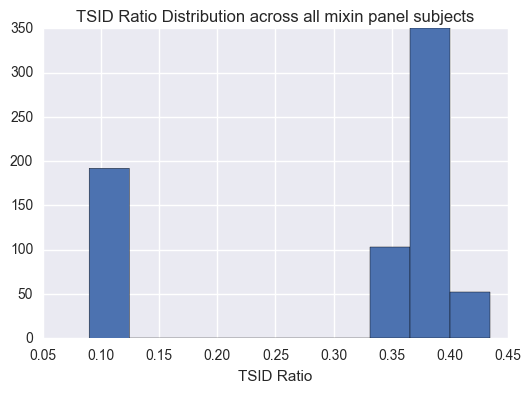

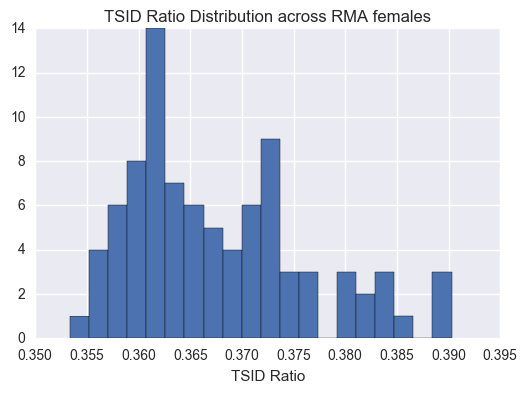

In [663]:
plt.figure()
plt.hist(coverage_df_M1.tsid_ratio)
plt.xlabel('TSID Ratio'), plt.title('TSID Ratio Distribution across all mixin panel subjects')

plt.figure()
plt.hist(coverage_df_RMA.tsid_ratio, bins=20)
plt.xlabel('TSID Ratio'), plt.title('TSID Ratio Distribution across RMA females')

There appears to be a subset of M1 subjects who were run on a very different version of the panel (with a significantly different TSID_only ratio -- around 0.1 instead of 0.38)

## TSID coverage distribution across RMA flowcells

In [662]:
print coverage_df.flow_cell_id.unique()
coverage_df.columns

['HGGF5AFXX' nan 'H533WAFXX' 'H7MWWAFXX' 'H7YMLAFXX' 'H2VLJAFXX'
 '000000000-AGDT3' 'H7VJGAFXX' 'H7G3KAFXX' '000000000-AT52C' 'HGGFJAFXX'
 '000000000-AAYUW' '000000000-AGD1M' '000000000-AJ573' 'HCMNKAFXX'
 'H5LHKAFXX' '000000000-AMJGN' 'HGKY2AFXX' 'H753VAFXX' 'HGVCHAFXX'
 'H52VTAFXX' '000000000-AD90E' 'H5FGFAFXX' '000000000-AHD8Y' 'HJH5FAFXX'
 '000000000-AHV0C' '000000000-AHU6L' '000000000-AD6V5' '000000000-AGD4F'
 '000000000-AMLHN' 'XXXXXXXXX']


Index([u'id', u'subject', u'specimen', u'sample', u'gender', u'sequencer',
       u'flow_cell_id', u'lane', u'bwa_version', u'date_modified',
       u'TSID_only', u'TSO_only', u'Ex1', u'Ex2', u'Ex3', u'Ex4', u'Ex5',
       u'Ex6', u'Ex7', u'Ex8', u'Ex9', u'Ex10', u'Ex11', u'Ex12', u'Ex13',
       u'Ex14', u'Ex15', u'Ex16', u'Ex17', u'Ex18', u'Ex19', u'Ex20', u'Ex21',
       u'Ex22', u'Ex23', u'Ex24', u'Ex25', u'Ex26', u'Ex27', u'Ex28', u'Ex29',
       u'Ex30', u'Ex31', u'Ex32', u'Ex33', u'Ex34', u'Ex35', u'Ex36', u'Ex37',
       u'Ex38', u'Ex39', u'Ex40', u'Ex41', u'Ex42', u'Ex43', u'Ex44', u'Ex45',
       u'Ex46', u'Ex47', u'Ex48', u'Ex49', u'Ex50', u'Ex51', u'Ex52', u'Ex53',
       u'Ex54', u'Ex55', u'Ex56', u'Ex57', u'Ex58', u'Ex59', u'Ex60', u'Ex61',
       u'Ex62', u'Ex63', u'Ex64', u'Ex65|66', u'Ex67', u'Ex68', u'Ex69',
       u'Ex70', u'Ex71', u'Ex72', u'Ex73', u'Ex74', u'Ex75', u'Ex76', u'Ex77',
       u'Ex78', u'Ex79', u'date', u'tsid_ratio'],
      dtype='object')

In [243]:
# coverage_df_RMA.drop('tsid_ratio', axis=1, inplace=True)
by_flow = coverage_df_RMA.groupby(['subject', 'flow_cell_id']).sum()
by_flow['tsid_ratio'] = by_flow.TSID_only / (by_flow.TSID_only + by_flow.TSO_only)
by_flow.reset_index(inplace=True)
by_flow.head()

,subject,flow_cell_id,TSID_only,TSO_only,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,...,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,tsid_ratio
0,FRMR-0070-444H,H7YMLAFXX,156976,282080,1595,187,483,724,384,665,...,219,453,373,590,265,290,392,149,378,0.357531
1,FRMR-0081-1987,H7YMLAFXX,160152,285380,1758,206,465,701,424,678,...,213,444,391,632,283,331,430,142,375,0.359462
2,FRMR-0085-579V,H7YMLAFXX,129883,229052,1265,166,378,589,355,548,...,158,336,307,500,225,273,381,139,312,0.361857
3,FRMR-00AG-860T,H7VJGAFXX,125027,214899,1162,142,298,603,340,379,...,140,310,276,412,171,218,292,101,268,0.367807
4,FRMR-00AW-8645,H7VJGAFXX,171201,271591,1718,237,510,750,399,619,...,194,516,437,673,346,329,467,211,464,0.386640


0.367750170657


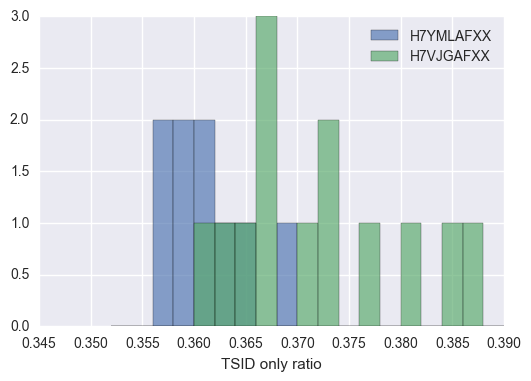

In [638]:
print np.mean(by_flow.tsid_ratio)
plt.figure()
for flowcell in by_flow.flow_cell_id.unique():
    plt.hist(by_flow[by_flow.flow_cell_id == flowcell].tsid_ratio, bins=20, alpha=0.65, label=flowcell, range=[0.35, 0.39])
plt.legend(loc='upper right')
plt.xlabel('TSID only ratio')
plt.show()

## Subset of M1/RMA subjects to correspond to test subject by tsid_ratio
Before trying to infer exon intensity values based on tsid_only ratios, we will simply estimate them based on data from subjects with similar tsid_only ratios. We subset the data (using subjects from different runs than the test subject when possible) and will later generate new intensity vectors (X_probs) to feed into the gibbs sampler.

### Subset for J0F1
This subject has a very large tsid_only ratio -- higher than any found in the RMA subject pool, so we take the subset from among all mixin panel subjects, making sure to exclude this subject herself. There seem to be only two other subjects (from the same run) with a similar tsid_ratio. 

In [330]:
# subsetting female mixin subjects with tsid_only ratios similar to that of subject J0F1
by_subject = coverage_df_M1[coverage_df_M1.gender == 'F'].groupby('subject').sum()
by_subject['tsid_ratio'] = by_subject.TSID_only / (by_subject.TSID_only + by_subject.TSO_only)
by_subject.head()

,TSID_only,TSO_only,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,...,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,tsid_ratio
subject,,,,,,,,,,,,,,,,,,,,,
FCLR-GP01-2121,51800,482527,874,154,350,532,233,400,372,331,...,196,325,257,514,205,312,328,102,242,0.096944
FCLR-GP08-753E,49210,445523,800,190,300,434,282,400,392,351,...,139,319,248,536,135,268,265,120,252,0.099468
FCLR-GP17-435H,30645,285049,482,99,194,259,164,255,264,232,...,106,226,146,315,103,174,194,80,142,0.097072
FCLR-GP20-399A,47471,439068,758,115,361,420,229,337,318,349,...,128,252,256,525,146,273,279,120,229,0.097569
FCLR-GP20-731O,45035,409323,679,165,314,384,252,332,298,275,...,128,260,235,445,104,205,275,99,235,0.099118


In [687]:
subject43 = list(by_subject[(by_subject.tsid_ratio > 0.41) & (by_subject.tsid_ratio < 0.47)].index)
subject43.remove('FGPC-4ZPF-J0F1')
m1_subset43 = coverage_df[coverage_df.subject.isin(subject43)]
# seeing if scale factor for gibbs is reasonable
total = m1_subset43[[column for column in m1_subset43 if 'Ex' in column]].sum(axis=1)
np.sum(total)

107251

### Subset for 822R and 444F
Neither of these subjects were run with the RMA samples, but they have very similar tsid_ratios to a subset of them.

In [276]:
subjects38 = by_flow[(by_flow.tsid_ratio < 0.39) & (by_flow.tsid_ratio > 0.37)]['subject']
subjects38

4     FRMR-00AW-8645
8     FRMR-00GC-803L
10    FRMR-00JD-7770
11    FRMR-00JM-865U
13    FRMR-00MM-839J
14    FRMR-00MS-704S
15    FRMR-00NC-7632
Name: subject, dtype: object

In [279]:
rma_subset = coverage_df_RMA[coverage_df_RMA.subject.isin(subjects38)]
rma_subset.head()

,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,date
161,FRMR-00NC-7632_1-M1-1_H7VJGAFXX-L001,FRMR-00NC-7632,FRMR-00NC-7632_1,FRMR-00NC-7632_1-M1-1,F,M1,H7VJGAFXX,L001,0.7.13-r1126,2016-06-24 22:24:30,...,56,83,86,162,57,81,105,31,117,2016-06-24
162,FRMR-00NC-7632_1-M1-1_H7VJGAFXX-L002,FRMR-00NC-7632,FRMR-00NC-7632_1,FRMR-00NC-7632_1-M1-1,F,M1,H7VJGAFXX,L002,0.7.13-r1126,2016-06-24 22:24:30,...,36,97,78,124,68,83,106,31,83,2016-06-24
163,FRMR-00NC-7632_1-M1-1_H7VJGAFXX-L003,FRMR-00NC-7632,FRMR-00NC-7632_1,FRMR-00NC-7632_1-M1-1,F,M1,H7VJGAFXX,L003,0.7.13-r1126,2016-06-24 22:24:30,...,44,90,80,131,58,71,100,38,94,2016-06-24
164,FRMR-00NC-7632_1-M1-1_H7VJGAFXX-L004,FRMR-00NC-7632,FRMR-00NC-7632_1,FRMR-00NC-7632_1-M1-1,F,M1,H7VJGAFXX,L004,0.7.13-r1126,2016-06-24 22:24:30,...,53,128,81,158,72,62,109,34,96,2016-06-24
206,FRMR-00GC-803L_1-M1-1_H7VJGAFXX-L001,FRMR-00GC-803L,FRMR-00GC-803L_1,FRMR-00GC-803L_1-M1-1,F,M1,H7VJGAFXX,L001,0.7.13-r1126,2016-06-25 04:41:41,...,62,164,114,180,107,100,140,38,141,2016-06-25


### Method to group by subject/sample and normalize

In [93]:
# function for reshaping data frames so that exons are observations (rows) and subjects are variables (columns)
# make sure datetimes have been converted to datetime objects before using
def reshape_df(df, include_stats=False, groupby='subject', subject_droplist=None, df_counts_wanted=False):
    df_grouped = df.groupby([groupby]).sum()
    df_norm = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    df_norm = df_norm.transpose().reset_index()
    df_norm.rename(columns={'index': 'Exon'}, inplace=True)

    if subject_droplist:
        for subject in subject_droplist:
            df_norm.drop(subject, axis=1, inplace=True)
    if include_stats:
        df_norm['Mean'] = df_norm.mean(axis=1)
        df_norm['SD'] = df_norm.std(axis=1)
    if df_counts_wanted:
        return df_norm, df_grouped
    else:
        return df_norm

## Investigating consistency between different T panels and P panels
T panels are TSO and P panels are TSID. Note that the T2-T4 panels here do not correspond to the labels used in the mixin experiment subjects further below. Unclear why these different sets of subjects have similar names. Also unsure what P2-P3 designate but they all seem to be TSID only subjects.

In [19]:
# how many subjects actually included in each sequencing panel set?
for panel, df in group_dict.items():
    print '{}: {}'.format(panel, len(df))

P2: 23
P3: 18
P1: 364
T4: 8
T2: 8
T3: 8
T1: 104
M1: 697


In [194]:
normed_dict = {panel: reshape_df(df, include_stats=True) for panel, df in group_dict.items()}

tso_means = pd.concat([normed_dict['T1'].Mean, normed_dict['T2'].Mean, normed_dict['T3'].Mean, normed_dict['T4'].Mean], axis=1)
tso_means.columns = ['t1', 't2', 't3', 't4']
tso_means.head()

,t1,t2,t3,t4
0,0.016845,0.014012,0.012813,0.012909
1,0.003514,0.002874,0.003533,0.003144
2,0.012617,0.010143,0.009760,0.012048
3,0.016752,0.013427,0.013768,0.013365
4,0.011578,0.008844,0.009217,0.010177


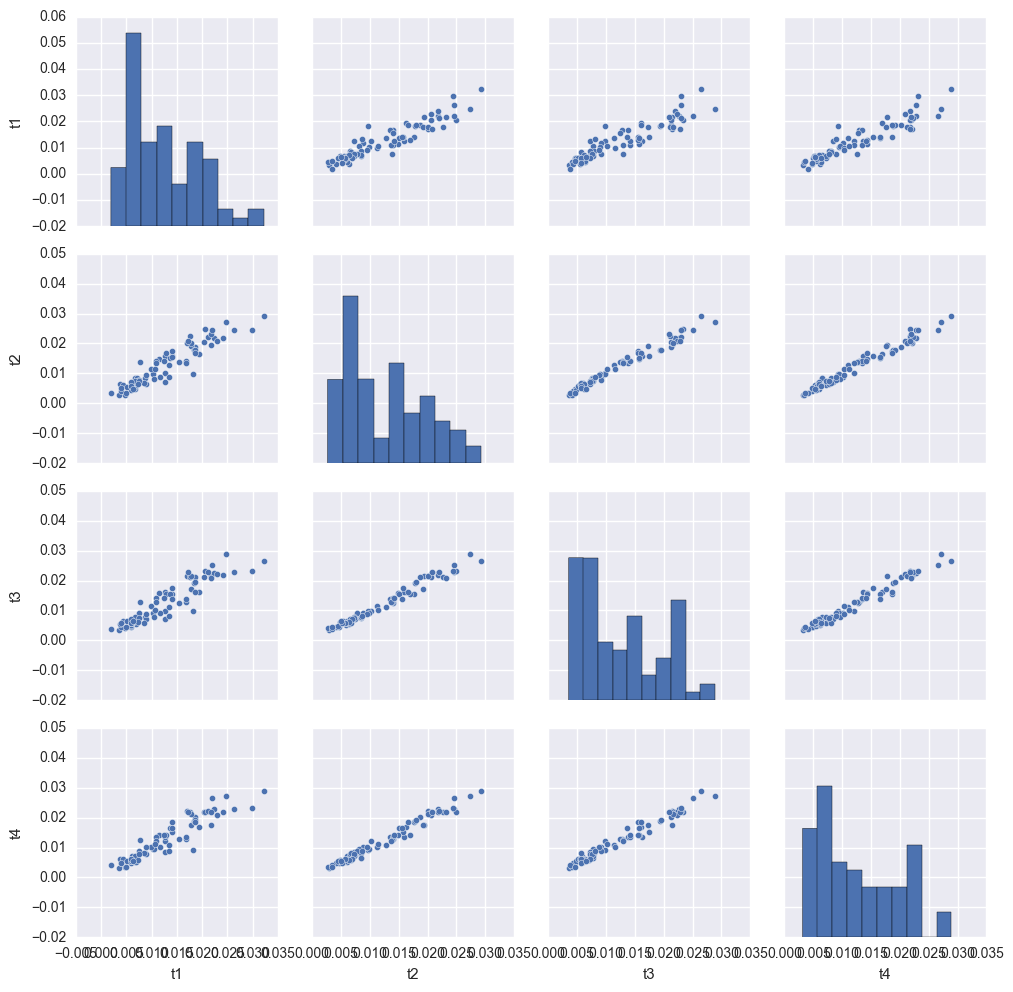

In [195]:
plt.figure()
g = sns.pairplot(tso_means)

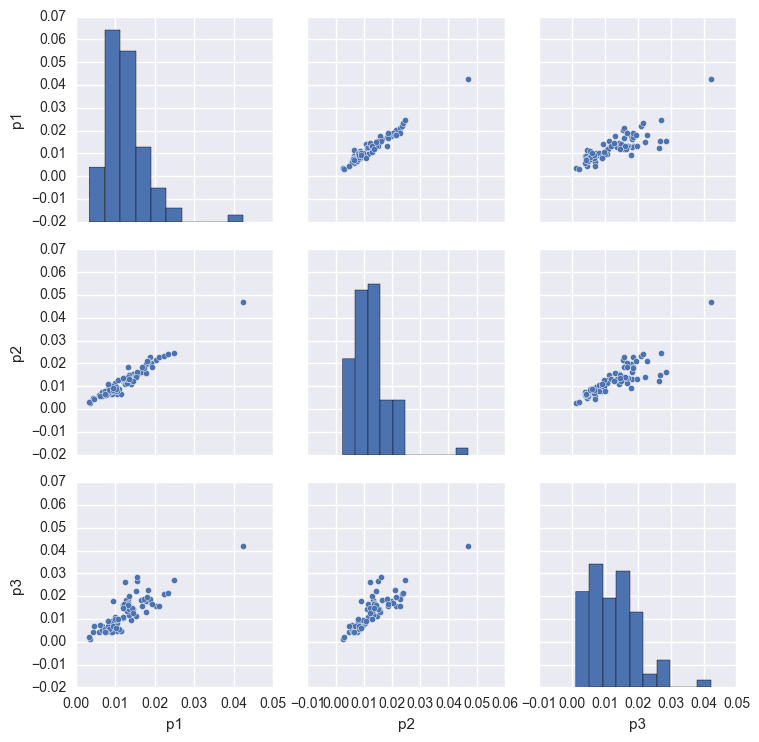

In [196]:
tsid_means = pd.concat([normed_dict['P1'].Mean, normed_dict['P2'].Mean, normed_dict['P3'].Mean], axis=1)
tsid_means.columns = ['p1', 'p2', 'p3']
plt.figure()
g2 = sns.pairplot(tsid_means)

(<matplotlib.text.Text at 0x111c27d90>, <matplotlib.text.Text at 0x111089610>)

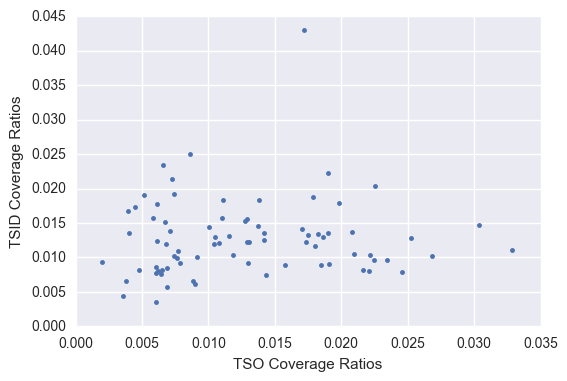

In [26]:
plt.figure()
plt.plot(tso_means.t1, tsid_means.p1, '.')
plt.xlabel('TSO Coverage Ratios'), plt.ylabel('TSID Coverage Ratios')

Coverage ratios between the largest groups of TSO and TSID subjects (T1 and P1 respectively) do not seem to correlate very well, indicating significantly different levels of coverage between the two panels.

## Mix-In Experiment Regression

In [109]:
def set_prop_tsid(row):
    if 'T2' in row.name:
        return 0.5
    elif 'T3' in row.name:
        return 0.33
    elif 'T4' in row.name:
        return 0.2
    else:
        return 1.0

In [138]:
# the exon of interest is 38 in the tsid panel, note use of tsid_exons_merged instead of DMD_exons_merged
# exon 54 is the region that contains the untranslated regions of two first exons
# exons 65/66 which have always been merged are now known as 69/70 in the tsid panel

tsid_exons_merged = util.merge_intervals(tsid_sorted, min_dist=200, include_index=True)
tsid_exon_labels = ['Ex' + exon['index'] for exon in tsid_exons_merged]
print 'The following exons were merged: {}'.format([exon['index'] for exon in tsid_exons_merged if not exon['index'].isdigit()]) 

The following exons were merged: ['53|54', '69|70']


In [180]:
reload(cov)
mixin_exp = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, tsid_exon_labels, bam_dir='../bams/mixin_exp')

Finished parsing all 12 subjects
376414 reads were skipped due to outside_of_exon
9005 reads were skipped due to MAPQ below 60


In [205]:
%%time
# this second dataset makes use of the total unique reads in TSO and TSID for these subjects
reload(DMD_util)
reload(cov)
mixin_exp2 = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, tsid_exon_labels, bam_dir='../bams/mixin_exp')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp
Finished parsing all 12 subjects
376414 reads were skipped due to outside_of_exon
9005 reads were skipped due to MAPQ below 60


CPU times: user 37min 41s, sys: 11.4 s, total: 37min 53s
Wall time: 38min 8s


In [353]:
%%time
# third dataset gets counts for just primary transcript exons -- used for multivariate linear regression
reload(DMD_util)
reload(cov)
mixin_exp3 = cov.coverageMatrix().create_coverage_matrix(DMD_exons_merged, exon_labels, bam_dir='../bams/mixin_exp')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp
Finished parsing all 12 subjects
428251 reads were skipped due to outside_of_exon
8843 reads were skipped due to MAPQ below 60


CPU times: user 12.1 s, sys: 650 ms, total: 12.7 s
Wall time: 13.3 s


In [359]:
rel_columns = ['sample'] + [column for column in mixin_exp3.columns if 'Ex' in column]
mixin3_groups = mixin_exp3[rel_columns].groupby('sample').sum()
mixin3_groups = mixin3_groups.div(mixin3_groups.sum(axis=1), axis=0)
mixin3_groups.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
sample,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F_1-T2-1,0.047601,0.004639,0.012802,0.016228,0.010851,0.014146,0.023587,0.019473,0.006507,0.013720,...,0.011786,0.004901,0.013228,0.010622,0.012687,0.008884,0.008163,0.011392,0.005131,0.011507
FGPC-0000-444F_1-T3-1,0.040143,0.005421,0.011037,0.016723,0.010452,0.012649,0.023756,0.018849,0.007281,0.012667,...,0.011674,0.004819,0.012915,0.011178,0.015005,0.009265,0.007511,0.011019,0.005173,0.009779
FGPC-0000-444F_1-T4-1,0.036070,0.004910,0.011416,0.014629,0.010353,0.012971,0.022424,0.017206,0.006138,0.013974,...,0.013258,0.004542,0.011703,0.010659,0.013728,0.007099,0.007856,0.010803,0.004501,0.009984
FGPC-0000-444F_1-T5-1,0.051883,0.003374,0.014001,0.012480,0.008434,0.015297,0.023116,0.018779,0.004878,0.014176,...,0.009514,0.002368,0.013968,0.007312,0.014151,0.010345,0.007553,0.011085,0.006132,0.010129
FPWB-0000-981L_1-T2-1,0.043080,0.005826,0.011771,0.014432,0.010908,0.016949,0.023230,0.021001,0.006545,0.014168,...,0.013041,0.005274,0.013569,0.011315,0.013329,0.009134,0.008750,0.011411,0.005034,0.009949


In [181]:
mixin_exp.date_modified = pd.to_datetime(mixin_exp.date_modified, unit='s')
mixin_exp['date'] = mixin_exp.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
mixin_exp.drop(['is_rerun'], axis=1, inplace=True)
print mixin_exp.subject.unique()
print mixin_exp.date.unique()

['FGPC-0000-444F' 'FPWB-0000-981L' 'FPWB-0001-1232']
[datetime.date(2017, 2, 28)]


In [182]:
mixin_exp_grouped = mixin_exp.groupby('sample').sum()
mixin_norm = mixin_exp_grouped.div(mixin_exp_grouped.sum(axis=1), axis=0)
mixin_norm['tsid_prop'] = mixin_norm.apply(set_prop_tsid, axis=1)
mixin_norm.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex77,Ex78,Ex79,Ex80,Ex81,Ex82,Ex83,Ex84,Ex85,tsid_prop
sample,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F_1-T2-1,0.043195,0.004209,0.011617,0.014726,0.009847,0.012837,0.021404,0.017671,0.005905,0.032203,...,0.009639,0.011513,0.008062,0.007407,0.010338,0.004656,0.010814,0.010531,0.027473,0.50
FGPC-0000-444F_1-T3-1,0.036531,0.004933,0.010044,0.015219,0.009512,0.011511,0.021619,0.017153,0.006626,0.031453,...,0.010173,0.013655,0.008432,0.006836,0.010028,0.004707,0.011204,0.008980,0.024585,0.33
FGPC-0000-444F_1-T4-1,0.033073,0.004502,0.010468,0.013413,0.009492,0.011893,0.020560,0.015777,0.005628,0.032041,...,0.009774,0.012587,0.006509,0.007204,0.009905,0.004127,0.009830,0.009248,0.023430,0.20
FGPC-0000-444F_1-T5-1,0.047463,0.003086,0.012808,0.011417,0.007715,0.013994,0.021147,0.017179,0.004462,0.032762,...,0.006689,0.012945,0.009464,0.006910,0.010140,0.005610,0.007921,0.009342,0.025191,1.00
FPWB-0000-981L_1-T2-1,0.039004,0.005274,0.010657,0.013067,0.009876,0.015346,0.021032,0.019014,0.005926,0.030995,...,0.010245,0.012068,0.008270,0.007922,0.010332,0.004558,0.010418,0.009029,0.027869,0.50


In [183]:
# performing the regression after removing the tsid only results (clearly not linear effect then)
mixin_norm2 = mixin_norm[mixin_norm.tsid_prop != 1.0]
regression = sm.ols(formula="Ex38 ~ tsid_prop", data=mixin_norm2).fit()
print regression.params

Intercept    0.002379
tsid_prop    0.011475
dtype: float64


In [184]:
print regression.summary()

                            OLS Regression Results                            
Dep. Variable:                   Ex38   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     81.34
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           4.21e-05
Time:                        18:56:37   Log-Likelihood:                 57.348
No. Observations:                   9   AIC:                            -110.7
Df Residuals:                       7   BIC:                            -110.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0024      0.000      5.127      0.0

/Users/velina/.pyenv/versions/2.7.11/envs/dmd/lib/python2.7/site-packages/scipy/stats/stats.py:1326: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


## Plotting coverage ratio of various individual exons as function of TSID proportion
Note that Exon 38 (first one) is the only one that appears exclusively in TSID.

(<matplotlib.text.Text at 0x10df3ff90>, <matplotlib.text.Text at 0x10dec9a50>)

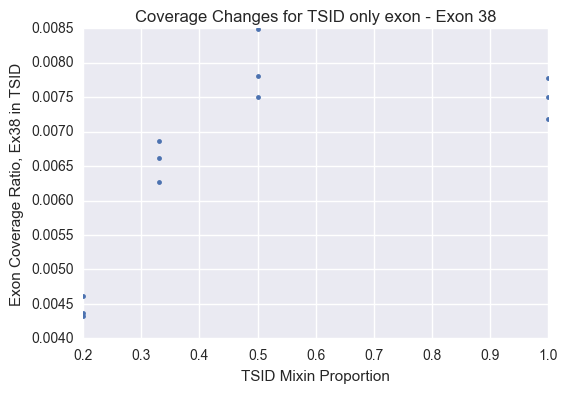

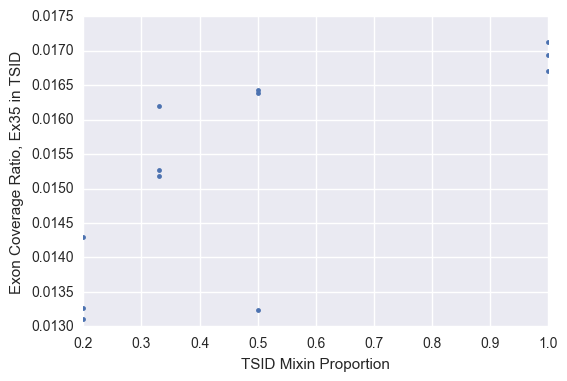

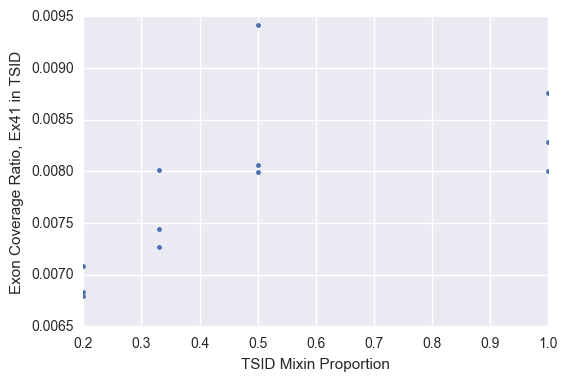

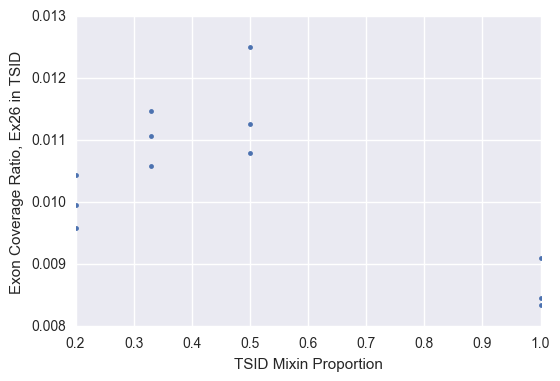

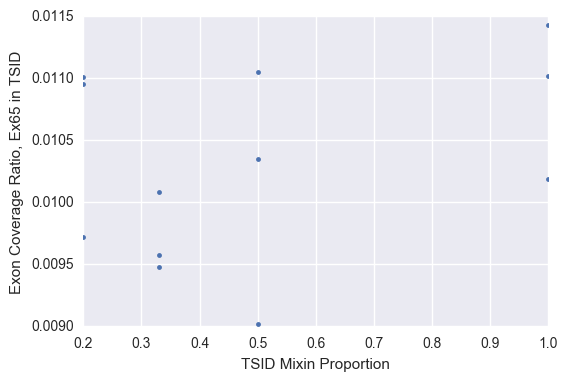

In [188]:
plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex38, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex38 in TSID')
plt.title('Coverage Changes for TSID only exon - Exon 38')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex35, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex35 in TSID')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex41, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex41 in TSID')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex26, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex26 in TSID')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex65, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex65 in TSID')

## Checking regression after using full TSID_only and TSO_only coverage counts

In [212]:
mixin_exp2.date_modified = pd.to_datetime(mixin_exp2.date_modified, unit='s')
mixin_exp2['date'] = mixin_exp2.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
# mixin_exp2.drop(['is_rerun'], axis=1, inplace=True)
print mixin_exp2.columns
mixin_exp2.head()

Index([u'id', u'subject', u'specimen', u'sample', u'gender', u'sequencer',
       u'flow_cell_id', u'lane', u'bwa_version', u'date_modified',
       u'TSID_only', u'TSO_only', u'Ex1', u'Ex2', u'Ex3', u'Ex4', u'Ex5',
       u'Ex6', u'Ex7', u'Ex8', u'Ex9', u'Ex10', u'Ex11', u'Ex12', u'Ex13',
       u'Ex14', u'Ex15', u'Ex16', u'Ex17', u'Ex18', u'Ex19', u'Ex20', u'Ex21',
       u'Ex22', u'Ex23', u'Ex24', u'Ex25', u'Ex26', u'Ex27', u'Ex28', u'Ex29',
       u'Ex30', u'Ex31', u'Ex32', u'Ex33', u'Ex34', u'Ex35', u'Ex36', u'Ex37',
       u'Ex38', u'Ex39', u'Ex40', u'Ex41', u'Ex42', u'Ex43', u'Ex44', u'Ex45',
       u'Ex46', u'Ex47', u'Ex48', u'Ex49', u'Ex50', u'Ex51', u'Ex52',
       u'Ex53|54', u'Ex55', u'Ex56', u'Ex57', u'Ex58', u'Ex59', u'Ex60',
       u'Ex61', u'Ex62', u'Ex63', u'Ex64', u'Ex65', u'Ex66', u'Ex67', u'Ex68',
       u'Ex69|70', u'Ex71', u'Ex72', u'Ex73', u'Ex74', u'Ex75', u'Ex76',
       u'Ex77', u'Ex78', u'Ex79', u'Ex80', u'Ex81', u'Ex82', u'Ex83', u'Ex84',
       u'Ex85', u'd

,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex77,Ex78,Ex79,Ex80,Ex81,Ex82,Ex83,Ex84,Ex85,date
0,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L004,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L004,0.7.10-r789,2017-02-28 15:28:23,...,154,169,156,113,162,78,180,196,486,2017-02-28
1,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L002,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L002,0.7.10-r789,2017-02-28 15:28:23,...,188,175,115,109,168,89,181,167,493,2017-02-28
2,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L003,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L003,0.7.10-r789,2017-02-28 15:28:23,...,162,199,115,147,184,71,191,164,463,2017-02-28
3,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L001,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L001,0.7.10-r789,2017-02-28 15:28:23,...,144,231,156,129,181,75,175,181,405,2017-02-28
4,FGPC-0000-444F_1-T3-1_H5FGFAFXX-L001,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T3-1,F,T3,H5FGFAFXX,L001,0.7.10-r789,2017-02-28 15:35:04,...,171,229,114,121,179,98,183,153,433,2017-02-28


In [223]:
# subset out just the relevant TSID/TSO only columns and other feature columns 
mixin_exp_rel = mixin_exp2[mixin_exp2.columns[:12]]
mixin_rel_grouped = mixin_exp_rel.groupby('sample').sum()
mixin_rel_norm = mixin_rel_grouped.div(mixin_rel_grouped.sum(axis=1), axis=0)
mixin_rel_norm['tsid_prop'] = mixin_rel_norm.apply(set_prop_tsid, axis=1)
# mixin_exp_rel['tsid_only_ratio'] = mixin_exp_rel.TSID_only / (mixin_exp_rel.TSID_only + mixin_exp_rel.TSO_only) 
#mixin_exp_rel['tsid_prop'] = mixin_exp_rel.apply(set_prop_tsid, axis=1)
mixin_rel_norm.head()

,TSID_only,TSO_only,tsid_prop
sample,,,
FGPC-0000-444F_1-T2-1,0.452893,0.547107,0.50
FGPC-0000-444F_1-T3-1,0.379855,0.620145,0.33
FGPC-0000-444F_1-T4-1,0.272864,0.727136,0.20
FGPC-0000-444F_1-T5-1,0.996140,0.003860,1.00
FPWB-0000-981L_1-T2-1,0.445154,0.554846,0.50


In [224]:
# redoing the regression after removing the tsid only results (clearly not linear effect then)
regression_full = sm.ols(formula="TSID_only ~ tsid_prop", data=mixin_rel_norm).fit()
print regression_full.params

Intercept    0.059965
tsid_prop    0.914812
dtype: float64


In [225]:
print regression_full.summary()

                            OLS Regression Results                            
Dep. Variable:              TSID_only   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     544.4
Date:                Thu, 02 Mar 2017   Prob (F-statistic):           4.74e-10
Time:                        12:00:49   Log-Likelihood:                 22.328
No. Observations:                  12   AIC:                            -40.66
Df Residuals:                      10   BIC:                            -39.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0600      0.023      2.586      0.0

/Users/velina/.pyenv/versions/2.7.11/envs/dmd/lib/python2.7/site-packages/scipy/stats/stats.py:1326: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


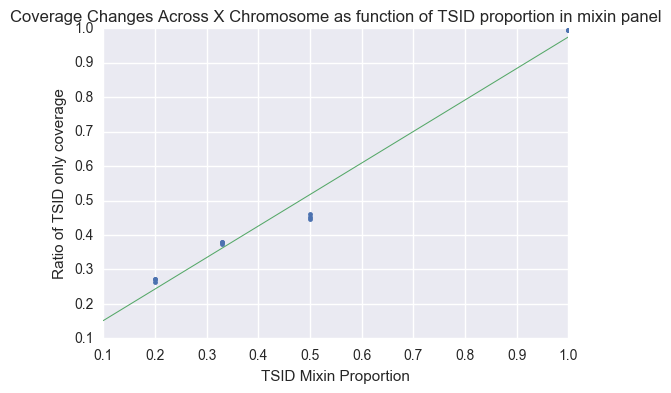

In [230]:
X_vec = np.linspace(0.1, 1, 100)
reg_vec = X_vec * regression_full.params[1] + regression_full.params[0]

plt.figure()
plt.plot(mixin_rel_norm.tsid_prop, mixin_rel_norm.TSID_only, '.')
plt.plot(X_vec, reg_vec, linewidth=0.75)
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Ratio of TSID only coverage')
plt.title('Coverage Changes Across X Chromosome as function of TSID proportion in mixin panel')
plt.show()

## Multivariate linear regression for exon intensity vector

In [408]:
merged = pd.merge(mixin_rel_norm, mixin3_groups, left_index=True, right_index=True)
merged.head()
# checking to see if results are improved after removing the 1.0, 1.0 point -- did not really change results much
merged_sub = merged[merged.tsid_prop != 1.0]
X = np.array(merged_sub.TSID_only).reshape(-1, 1) # cannot pass 1-d array into sklearn 0.19
X_2 = np.power(X, 2)
X_3 = np.power(X, 3)
# adding polynomial terms to feature dataset
X_square = np.concatenate((X, X_2), axis=1)
Y = merged_sub[merged_sub.columns[3:]].values

In [455]:
print Y.shape
print X_square.shape
merged.head()

(9, 78)
(9, 2)


,TSID_only,TSO_only,tsid_prop,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
sample,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F_1-T2-1,0.452893,0.547107,0.50,0.047601,0.004639,0.012802,0.016228,0.010851,0.014146,0.023587,...,0.011786,0.004901,0.013228,0.010622,0.012687,0.008884,0.008163,0.011392,0.005131,0.011507
FGPC-0000-444F_1-T3-1,0.379855,0.620145,0.33,0.040143,0.005421,0.011037,0.016723,0.010452,0.012649,0.023756,...,0.011674,0.004819,0.012915,0.011178,0.015005,0.009265,0.007511,0.011019,0.005173,0.009779
FGPC-0000-444F_1-T4-1,0.272864,0.727136,0.20,0.036070,0.004910,0.011416,0.014629,0.010353,0.012971,0.022424,...,0.013258,0.004542,0.011703,0.010659,0.013728,0.007099,0.007856,0.010803,0.004501,0.009984
FGPC-0000-444F_1-T5-1,0.996140,0.003860,1.00,0.051883,0.003374,0.014001,0.012480,0.008434,0.015297,0.023116,...,0.009514,0.002368,0.013968,0.007312,0.014151,0.010345,0.007553,0.011085,0.006132,0.010129
FPWB-0000-981L_1-T2-1,0.445154,0.554846,0.50,0.043080,0.005826,0.011771,0.014432,0.010908,0.016949,0.023230,...,0.013041,0.005274,0.013569,0.011315,0.013329,0.009134,0.008750,0.011411,0.005034,0.009949


In [496]:
# fitting multivariate linear model across intensity vector as function of tsid_only ratio and squared term
linmodel = linear_model.LinearRegression() 
linmodel.fit(X_square, Y)
coeff = linmodel.coef_.flatten()
interc = linmodel.intercept_

In [495]:
# testing the fitted model on the individual RMA exon intensities
rma_tsid_ratio = np.array(by_flow.tsid_ratio).reshape(-1,1)
rma_tsid2 = np.power(rma_tsid_ratio, 2)
rma_square = np.concatenate((rma_tsid_ratio, rma_tsid2), axis=1)
# note that RMA_norm is taken from a lower cell (in Gibbs sampling section) so that must be run first
rma_matrix = RMA_norm[RMA_norm.columns[1:-2]].values.T
rma_matrix.shape
rma_matrix

array([[ 0.03989694,  0.00467757,  0.01208164, ...,  0.00980539,
         0.00372705,  0.0094552 ],
       [ 0.0432909 ,  0.00507277,  0.01145066, ...,  0.01058879,
         0.00349676,  0.00923441],
       [ 0.03841715,  0.0050413 ,  0.01147959, ...,  0.0115707 ,
         0.00422133,  0.00947522],
       ..., 
       [ 0.03731915,  0.00634043,  0.0107234 , ...,  0.01178723,
         0.00302128,  0.00982979],
       [ 0.04511839,  0.00593663,  0.01428184, ...,  0.00868444,
         0.00451184,  0.01017708],
       [ 0.04069184,  0.00573958,  0.01328083, ...,  0.01044964,
         0.00360333,  0.01037243]])

In [446]:
linmodel.predict(rma_square)

array([[ 0.04087542,  0.00507775,  0.01164833, ...,  0.0113592 ,
         0.00484648,  0.01045183],
       [ 0.04097497,  0.00508312,  0.01165705, ...,  0.01136561,
         0.00486056,  0.01046297],
       [ 0.04109846,  0.00508952,  0.01166758, ...,  0.01137309,
         0.0048779 ,  0.01047678],
       ..., 
       [ 0.04146719,  0.00510697,  0.01169725, ...,  0.01139231,
         0.00492899,  0.01051797],
       [ 0.04139044,  0.00510354,  0.0116913 , ...,  0.01138869,
         0.00491845,  0.01050941],
       [ 0.04109321,  0.00508926,  0.01166714, ...,  0.01137279,
         0.00487717,  0.01047619]])

In [452]:
# should return coefficient of determination r2 - why is this negative?
linmodel.score(rma_square, rma_matrix)

-1.0696457047537187

In [439]:
# generating values to create null model for testing LinearRegression().score()
X_basic = np.ones((9,2))
Y_basic = np.mean(rma_matrix, axis=0)
Y_mean = np.multiply(Y_basic, np.ones((9,78)))

In [454]:
# verifying whether LinearRegression().score() actually returns 0 for null model -- yes it does within tiny error
linmodel_null = linear_model.LinearRegression()
linmodel_null.fit(X_basic, Y_mean)
linmodel_null.score(rma_square, rma_matrix)

-2.2797204113751495e-17

### Looking at individual exon coverages as function of tsid_ratio

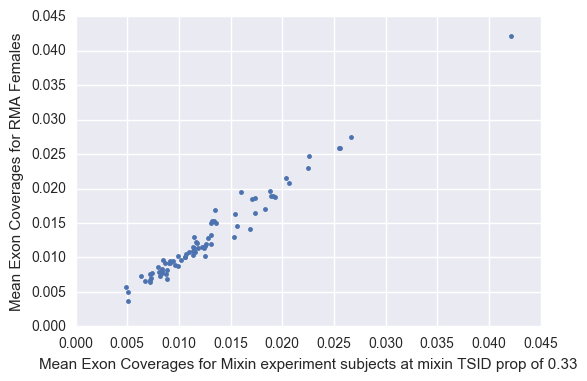

In [497]:
# first let's make sure we didn't screw up the order of the exons in training and then testing our linear regression
# we should see fairly high correlation along y = x
by_tsidprop = merged.groupby('tsid_prop').mean()
mixin_third_tsid = np.array(by_tsidprop.loc[0.33][2:])
plt.figure()
# remember that X_probs is the mean exon coverages of the RMA females - must be run on a lower cell first 
plt.plot(mixin_third_tsid, X_probs, '.')
plt.xlabel('Mean Exon Coverages for Mixin experiment subjects at mixin TSID prop of 0.33')
plt.ylabel('Mean Exon Coverages for RMA Females')

(<matplotlib.text.Text at 0x115cf7390>,
 <matplotlib.text.Text at 0x115d7e110>)

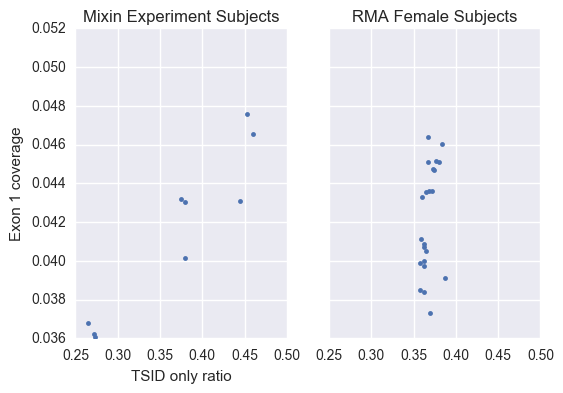

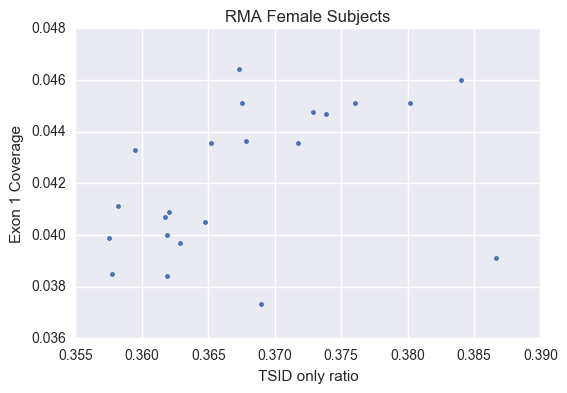

In [501]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.plot(merged.TSID_only, merged.Ex1, '.')
ax1.set_ylabel('Exon 1 coverage'), ax1.set_xlabel('TSID only ratio')
ax1.set_xlim([0.25, 0.5])
ax1.set_title('Mixin Experiment Subjects')

ax2.plot(rma_tsid_ratio.flatten(), rma_matrix[:,0], '.')
ax2.set_title('RMA Female Subjects')

plt.figure()
plt.plot(rma_tsid_ratio.flatten(), rma_matrix[:,0], '.')
plt.xlabel('TSID only ratio'), plt.ylabel('Exon 1 Coverage'), plt.title('RMA Female Subjects')

(<matplotlib.text.Text at 0x112261990>,
 <matplotlib.text.Text at 0x1138dc750>)

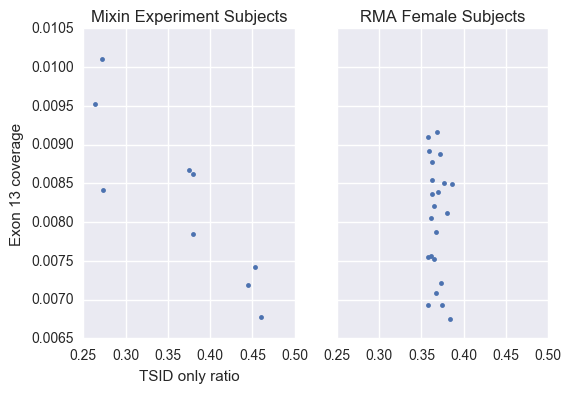

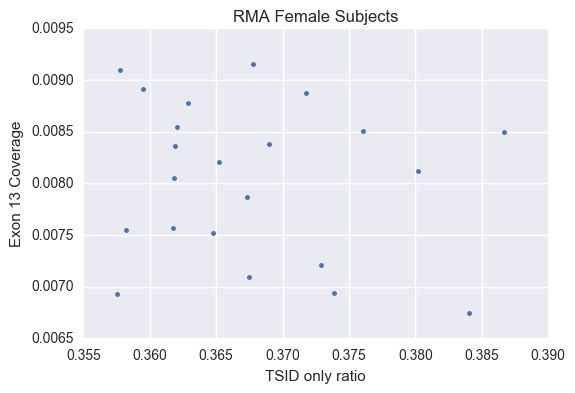

In [617]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.plot(merged.TSID_only, merged.Ex13, '.')
ax1.set_ylabel('Exon 13 coverage'), ax1.set_xlabel('TSID only ratio')
ax1.set_xlim([0.25, 0.5])
ax1.set_title('Mixin Experiment Subjects')

ax2.plot(rma_tsid_ratio.flatten(), rma_matrix[:,12], '.')
ax2.set_title('RMA Female Subjects')

plt.figure()
plt.plot(rma_tsid_ratio.flatten(), rma_matrix[:,12], '.')
plt.xlabel('TSID only ratio'), plt.ylabel('Exon 13 Coverage'), plt.title('RMA Female Subjects')

(<matplotlib.text.Text at 0x116aa0410>,
 <matplotlib.text.Text at 0x116222090>)

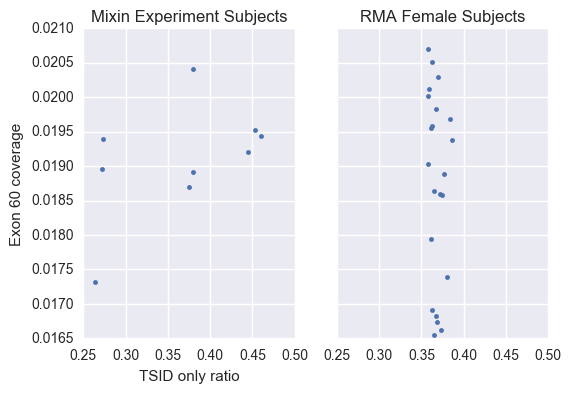

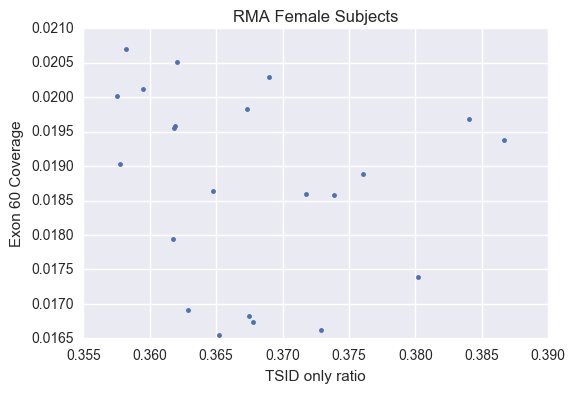

In [502]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.plot(merged.TSID_only, merged.Ex60, '.')
ax1.set_ylabel('Exon 60 coverage'), ax1.set_xlabel('TSID only ratio')
ax1.set_xlim([0.25, 0.5])
ax1.set_title('Mixin Experiment Subjects')

ax2.plot(rma_tsid_ratio.flatten(), rma_matrix[:,59], '.')
ax2.set_title('RMA Female Subjects')

plt.figure()
plt.plot(rma_tsid_ratio.flatten(), rma_matrix[:,59], '.')
plt.xlabel('TSID only ratio'), plt.ylabel('Exon 60 Coverage'), plt.title('RMA Female Subjects')

There seems to be a lot more exon coverage variation within the RMA data than can be explained simply by the TSID_only ratio. Will probably have to incorporate latent variable representing underlying exon intensities as they don't seem to be easily inferred from the TSID ratio. 

## Gibbs Sampling -- new and improved


The full gene product of DMD consists of 78 exons, each with its own copy number in each subject ($\mathbf{C} = \{c_1, c_2, ..., c_{78}\}$), where $c_i \in{1,2,3...}$ For this simple model, assume that the $c_i$ are distributed discrete uniformly with support $ \{1,2,3\}$. 

This model also includes "intensity" values across the exons $\mathbf{X}= \{x_1, x_2,..., x_{78}\}$, and we let $$\mathbf{P} = \dfrac{\mathbf{C}\mathbf{X}}{\sum_i c_ix_i} = \{p_1, p_2, ..., p_{78}\}$$ 
From here we let $k = 78$ to represent the model more generally.

Thus our generative model assumes that the reads for every sequencing run (whether simulated or real) are distributed according to a multinomial distribution with probability vector $\mathbf{P}$. Furthermore, we assume that $\mathbf{X}$ are drawn from a Dirichlet distribution with known vector of priors $\mathbf{\gamma}$. If we let $\mathbf{Y}$ represent the data from a single subject (where $y_i$ represents the number of reads mapped to exon $i$), we can write the joint distribution as:

$$ 
\begin{align}
\Pr(\mathbf{C}, \mathbf{Y}, \mathbf{X}; \mathbf{\gamma}) \;\; &\propto \;\;\prod_{i=1}^k p_i^{y_i} \prod_{i=1}^k x_i^{\gamma_i - 1} \\
&\propto \;\;\prod_{i=1}^k \left(\dfrac{c_ix_i}{\sum c_ix_i}\right)^{y_i} \prod_{i=1}^k x_i^{\gamma_i - 1} \\
&\propto \;\;\left(\dfrac{1}{\sum c_ix_i}\right)^\mathbb{T} \prod_{i=1}^k \left(c_ix_i\right)^{y_i} \prod_{i=1}^k x_i^{\gamma_i - 1} \\
&\propto \;\;\left(\dfrac{1}{\sum c_ix_i}\right)^\mathbb{T} \prod_{i=1}^k c_i^{y_i} x_i^{y_i + \gamma_i - 1}
\end{align}
$$
Note that we have left out the normalization constants for the multinomial and Dirichlet distributions and $\mathbb{T} = \sum_i y_i$ represents the total number of reads in $\mathbf{Y}$. Thus the complete joint distribution would be 
$$ \Pr(\mathbf{C}, \mathbf{Y}, \mathbf{X}; \mathbf{\gamma}) \;\; = \;\; \dfrac{\mathbb{T}!}{y_1!... y_k!} \dfrac{\Gamma (\sum \gamma_i)}{\prod \Gamma (\gamma_i)}\left(\dfrac{1}{\sum c_ix_i}\right)^\mathbb{T} \prod_{i=1}^k c_i^{y_i} x_i^{y_i + \gamma_i - 1} $$

**Running the Gibbs Sampler**

Initialize the intensities $\mathbf{X}$ from $\text{Dirichlet}(\gamma)$ where the desired coverage ratios have been appropriately scaled to increase the bias of the prior. Initialize $c_i$ values based on basic prior distribution. If testing (without subject data), we can also generate fake subject data. 

At each iteration $t$, sample $c_i^t$ from the posterior distribution
$$f_{C^t|Y, C_{-i}^t}(c) = \dfrac{\left(\dfrac{1}{\sum c_jx_j}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_i} x_j^{y_j + \gamma_j - 1} \vert c_i = c} {\sum_c \left(\dfrac{1}{\sum c_jx_j}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_i} x_j^{y_j + \gamma_j - 1} \vert c_i = c}$$ 
where $$ \mathbf{C_{-i}}^t = \{ c_1^t,...c_{i-1}^t, c_{i+1}^{t-1}, ... c_{78}^{t-1} \}$$



Normally this expression would include the prior distribution over $c$ but it easily cancels out as the uniform. (This expression also does not include the multinomial or dirichlet constants).

At the end of each iteration, we also need to resample $\mathbf{X}$. Normally the Dirichlet is the conjugate prior of the multinomial, but in our case we have the more complex posterior:

$$ \prod_{i=1}^k \dfrac{x_i^{y_i + \gamma_i -1}}{\left(\sum c_ix_i \right)^{y_i}} $$

**Implementation considerations**: $\prod_{j=1}^k c_j^{y_i} x_j^{y_j + \gamma_j - 1}$ can cause under/overflow in Python (or washout of values too close to 0)

**Solution**: Convert to log space and divide by the maximal likelihood to normalize (and keep values from shrinking too close to 0):

In other words, calculate the value below for each $c_i = c$ and then divide by their sum to normalize.
$$ \exp\left(-\mathbb{T} \log(\sum c_jx_j) +  \sum (y_j \log c_j + (y_j + \gamma_j -1)\log x_j) - \max_c \left( -\mathbb{T} \log(\sum c_jx_j) +  \sum (y_j \log c_j + (y_j + \gamma_j -1)\log x_j) \right) \right)$$ 

Store the $C^t$ values only for iterations $t=1000... 10,000$. This allows for a burn-in period of 1000 iterations during which the sampling distributions are likely to be least accurate. To reduce auto-correlation, only include every hundredth sampling in final analysis as well. For each exon $i$, count the proportions of samples falling into each possible copy number across the relevant subset of iterations. 


### Next Steps
* Incorporate more complex and representative prior for the copy number distribution (in particular, there should be higher prior probability for 2 copies of exon)
* Determine more accurate estimate of burn-in period (strange log-likelihood behavior, should converge as iterations increase)
* Account for increased likelihood of copy number correlation between neighboring exons
* Consider modifying prior for two exon deletion hotspots (around 45-50 and 18-20)
* **Incorporate step for correcting for mixin-based discrepancies**


In [619]:
X_probs 

array([ 0.04215466,  0.00503887,  0.01219685,  0.01949855,  0.01014229,
        0.01530697,  0.02292741,  0.01966598,  0.00658655,  0.01536095,
        0.01302953,  0.00913421,  0.0080407 ,  0.00969923,  0.01683406,
        0.00958058,  0.01332116,  0.0064703 ,  0.01296143,  0.02752234,
        0.01172826,  0.01629112,  0.01099417,  0.00869235,  0.02590953,
        0.00953366,  0.01891899,  0.00953329,  0.01449503,  0.00728083,
        0.01279229,  0.00914364,  0.01849212,  0.00803307,  0.01080465,
        0.01037349,  0.01150525,  0.00775733,  0.01022832,  0.01134996,
        0.01079948,  0.00765549,  0.0149941 ,  0.01410612,  0.02586731,
        0.00834665,  0.02153014,  0.01143097,  0.02477873,  0.00813239,
        0.0091945 ,  0.00700924,  0.01860981,  0.00758001,  0.02073513,
        0.00858007,  0.00671624,  0.00783585,  0.01204692,  0.01874403,
        0.01044444,  0.01646457,  0.00729369,  0.01199439,  0.01896777,
        0.01145101,  0.01696939,  0.00884788,  0.01135852,  0.00

In [802]:
def generate_gibbs_df(cnv_support, X_priors, data=None, cnv=None, scale=7e4, sim_reads=3e4, iterations=10000, burn_in=1000,
                      df_wanted=True, exon_labels=None):
    '''Performs Gibbs sampling given a support vector for CNVs, an intensity vector and subject data (optional)'''
    # initialization of cnv counts and intensity vector
    if cnv is None:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(X_priors)) 
    print cnv
    # we're using a scaling factor for the X_priors (small ratios give too much variability in the dirichlet)
    X_vect = np.random.dirichlet(X_priors * scale)
    # consider returning this vector along with initial cnv vector
    normed_probs_first = np.multiply(cnv, X_vect) / np.sum(np.multiply(cnv, X_vect))
    # for testing only
    if data is None:
        data = np.random.multinomial(sim_reads, normed_probs_first)
    
    gibbs_cnv_data = np.zeros((len(X_priors), iterations))
    gibbs_X = np.zeros((iterations, len(X_priors)))
    likelihoods = np.zeros(iterations)
#     testing = []
    
    # begin iterations
    for i in range(iterations):
        if iterations > 20 and (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        # sample all cnv values
        for exon in range(len(X_priors)):
            test = np.zeros(len(cnv_support))
            old = cnv[exon]
            for value in cnv_support:
                cnv[exon] = value
                # get new normed probabilities given test value and priors for exon intensities
                log_probs_norm = np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, X_vect)))
                log_likelihood = (log_probs_norm + 
                                 np.sum(np.multiply(np.log(cnv), data) + 
                                        np.multiply((data + (X_priors * scale) - 1), np.log(X_vect))))
                test[value - 1] = log_likelihood
            test = test - np.max(test)
            sample_probs = np.exp(test)
            sample_probs = sample_probs / np.sum(sample_probs)
            new_cnv = np.random.choice(cnv_support, p = sample_probs)
#             testvalue1 = np.log(sample_probs[new_cnv-1]) - np.log(sample_probs[old-1])
#             testvalue2 = test[new_cnv-1] - test[old - 1]
#             testing.append(testvalue1 - testvalue2 < 0.000001)
            cnv[exon] = new_cnv
            gibbs_cnv_data[exon, i] = new_cnv
        # sample new X_vect after updating with data -- this is not the real posterior
        X_vect = np.random.dirichlet(X_priors * scale + data)
        gibbs_X[i] = X_vect
        
        log_probs = np.log(np.multiply(cnv, X_vect) / np.sum(np.multiply(cnv, X_vect)))
        likelihoods[i] = np.sum(np.multiply(log_probs, data))
    
#     print len(testing)
#     print all(testing)
    # get proportions using burn-in of 1000 iterations 
    gibbs_data_results = np.zeros((len(X_priors), len(cnv_support)))
    for index in range(len(X_priors)):
        # exclude samples before burn in and then take only every 100th sample to reduce autocorrelation
        gibbs_slice = gibbs_cnv_data[index][burn_in:][::100]
        gibbs_data_results[index] = np.bincount(gibbs_slice.astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    gibbs_data_results = gibbs_data_results / float(len(gibbs_slice))
    
    # return df for easier visualization
    if df_wanted:
        gibbs_df = pd.DataFrame(gibbs_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support])
        gibbs_df['Exon'] = exon_labels
        return gibbs_cnv_data, gibbs_X, gibbs_data_results, likelihoods, gibbs_df
    
    return gibbs_cnv_data, gibbs_X, gibbs_data_results, likelihoods

## Rerunning Gibbs Sampling with varying intensity vectors
The gibbs sampling done here will be performed with intensity vectors based on subsets of subjects with similar TSID_only ratios to the individual test subject. 

In [391]:
# use RMA samples for initial intensity vector -- note that all RMA individuals used the M1 mixin panel
# this is only the females in RMA
print coverage_df_RMA.sequencer.unique()
rma_ex = coverage_df_RMA[gibbs_columns]
RMA_norm = reshape_df(rma_ex, include_stats=True)
RMA_norm.head()
X_probs = np.array(RMA_norm.Mean)
print len(X_probs)
X_probs
RMA_norm.head()

['M1']
78


subject,Exon,FRMR-0070-444H,FRMR-0081-1987,FRMR-0085-579V,FRMR-00AG-860T,FRMR-00AW-8645,FRMR-00BB-772T,FRMR-00CS-821F,FRMR-00DM-853C,FRMR-00GC-803L,...,FRMR-00MS-704S,FRMR-00NC-7632,FRMR-00SA-876L,FRMR-00SB-851W,FRMR-00SC-714V,FRMR-00SD-679G,FRMR-00ST-841F,FRMR-00TS-8464,Mean,SD
0,Ex1,0.039897,0.043291,0.038417,0.043620,0.039123,0.040485,0.039708,0.040878,0.045125,...,0.043579,0.046018,0.038485,0.039989,0.043555,0.037319,0.045118,0.040692,0.042155,0.002726
1,Ex2,0.004678,0.005073,0.005041,0.005331,0.005397,0.004894,0.004709,0.004108,0.005038,...,0.005191,0.004444,0.004449,0.005499,0.004628,0.006340,0.005937,0.005740,0.005039,0.000552
2,Ex3,0.012082,0.011451,0.011480,0.011187,0.011614,0.012285,0.012389,0.012783,0.012536,...,0.012038,0.012118,0.012041,0.012671,0.011442,0.010723,0.014282,0.013281,0.012197,0.000780
3,Ex4,0.018110,0.017262,0.017888,0.022636,0.017079,0.015429,0.021727,0.019059,0.020194,...,0.021530,0.021213,0.019180,0.017283,0.019932,0.015830,0.021847,0.021208,0.019499,0.002122
4,Ex5,0.009605,0.010441,0.010781,0.012763,0.009086,0.009238,0.011827,0.011468,0.009755,...,0.009813,0.008397,0.010155,0.009478,0.009228,0.010383,0.010177,0.010012,0.010142,0.000944


In [303]:
# more refined subset based on tsid_ratios
gibbs_columns = ['subject'] + [column for column in rma_subset.columns if 'Ex' in column]

rma38 = rma_subset[gibbs_columns]
rma38_norm = reshape_df(rma38, include_stats=True)
X_probs38 = np.array(rma38_norm.Mean)
rma38_norm.head()

subject,Exon,FRMR-00AW-8645,FRMR-00GC-803L,FRMR-00JD-7770,FRMR-00JM-865U,FRMR-00MM-839J,FRMR-00MS-704S,FRMR-00NC-7632,Mean,SD
0,Ex1,0.039123,0.045125,0.045128,0.044675,0.044764,0.043579,0.046018,0.044059,0.002124
1,Ex2,0.005397,0.005038,0.005161,0.005173,0.004583,0.005191,0.004444,0.004998,0.000324
2,Ex3,0.011614,0.012536,0.012873,0.012155,0.011836,0.012038,0.012118,0.012167,0.000391
3,Ex4,0.017079,0.020194,0.020702,0.021155,0.020224,0.021530,0.021213,0.020300,0.001395
4,Ex5,0.009086,0.009755,0.010380,0.010345,0.010234,0.009813,0.008397,0.009716,0.000682


In [741]:
test_scale = 3e4
test_mse = []
# print scipy.stats.dirichlet.mean(test_scale * np.array(rma38_norm.Mean))
print np.power(np.array(rma38_norm.SD), 2)
print scipy.stats.dirichlet.var(1.7e4 * np.array(rma38_norm.Mean))
# for i in range(len(rma38_norm.columns) - 3):
#     test_pdf.append(scipy.stats.dirichlet.pdf(rma38_norm[rma38_norm.columns[i+1]], test_scale * rma38_norm.Mean))
# test_pdf
for i in np.linspace(0.1, 10, 100):
    test_scale = i * 1e4
    sample_var = np.power(np.array(rma38_norm.SD)[1:], 2)
    dir_var = scipy.stats.dirichlet.var(test_scale * np.array(rma38_norm.Mean)[1:])
    mse = np.mean(np.square(sample_var - dir_var))
    test_mse.append(mse)

[  4.51288618e-06   1.04841442e-07   1.52665496e-07   1.94712220e-06
   4.64597497e-07   2.64857077e-06   2.76699878e-06   5.53924561e-07
   2.39413775e-07   6.70546053e-07   4.36535102e-07   3.14621056e-07
   6.33629856e-07   6.68560886e-08   1.07180846e-06   3.07127719e-07
   1.09843232e-06   1.21862016e-07   1.21106937e-06   1.66611969e-06
   7.98581676e-07   6.21120498e-07   5.67704903e-07   6.44884301e-07
   6.15230736e-07   8.97684875e-07   2.34245009e-06   2.31578253e-07
   7.98362370e-07   4.22333112e-07   1.38605569e-07   5.25180328e-07
   1.35902452e-06   1.02318248e-06   6.62485467e-07   1.12283187e-06
   1.56995061e-06   8.49927042e-07   2.27578872e-07   5.86724035e-07
   2.43451361e-07   7.89526673e-07   1.03612278e-06   1.68796636e-06
   2.06001009e-06   5.90821403e-07   1.20270314e-06   5.93455486e-07
   2.56890064e-06   4.11123915e-07   9.05985572e-07   7.84081775e-07
   4.27119593e-07   4.21728937e-07   6.08296535e-07   2.03837445e-07
   1.15396492e-07   1.93552139e-07

In [740]:
np.linspace(0.1, 10, 100)[np.argmin(test_mse)]

1.7000000000000002

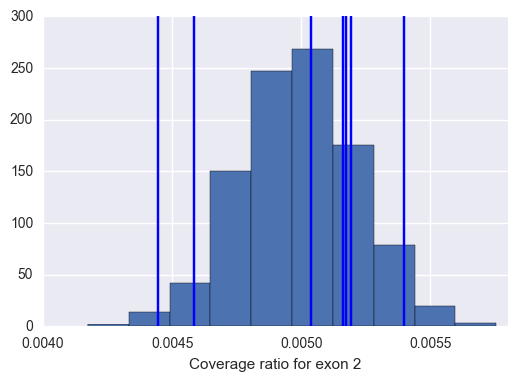

In [801]:
test_scale = 9e4
test_many = np.random.dirichlet(test_scale * np.array(rma38_norm.Mean), 1000)
plt.figure()
plt.hist(test_many[:, 1])
plt.xlabel('Coverage ratio for exon 2')
for cover in rma38_norm.iloc[1][1:-2]:
    plt.axvline(x=cover)

In [346]:
# subset for subject J0F1 
m1_43 = m1_subset43[gibbs_columns]
m1_43_norm = reshape_df(m1_43, include_stats=True)
X_probs43 = np.array(m1_43_norm.Mean)
m1_43_norm.head()

subject,Exon,FGPC-1PR1-SON4,FGPC-INSR-YI4C,Mean,SD
0,Ex1,0.050868,0.050952,0.050910,0.000042
1,Ex2,0.006013,0.006189,0.006101,0.000088
2,Ex3,0.011639,0.011508,0.011573,0.000066
3,Ex4,0.018458,0.020505,0.019482,0.001024
4,Ex5,0.010982,0.012079,0.011531,0.000549


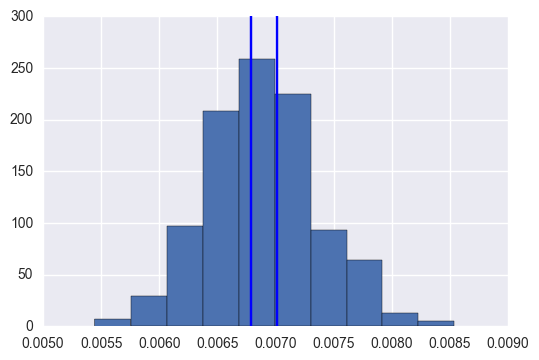

In [719]:
test_scale = 3e4
test_many = np.random.dirichlet(test_scale * np.array(m1_43_norm.Mean), 1000)
plt.figure()
plt.hist(test_many[:, 12])
for cover in m1_43_norm.iloc[12][1:-2]:
    plt.axvline(x=cover)

In [680]:
# generating coverage counts for superset of exons
reload(cov)
test_subjects_num = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, 
                                                                tsid_exon_labels, bam_dir='../bams/test_subjects')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp
Finished parsing all 6 subjects
165124 reads were skipped due to outside_of_exon
4612 reads were skipped due to MAPQ below 60


In [286]:
%%time
# generating coverage counts for only primary transcript exons, note that this will run slowly if coverageMatrix()
# code has not been updated 
reload(cov)
test_subjects_prim = cov.coverageMatrix().create_coverage_matrix(DMD_exons_merged, 
                                                                 exon_labels, bam_dir='../bams/test_subjects')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp
Finished parsing all 6 subjects
187493 reads were skipped due to outside_of_exon
4492 reads were skipped due to MAPQ below 60


CPU times: user 5.51 s, sys: 102 ms, total: 5.61 s
Wall time: 5.69 s


In [287]:
# test_subjects = pd.DataFrame(coverage_matrix[1:], columns=coverage_matrix[0])
# test_subjects_num = test_subjects.apply(lambda x: pd.to_numeric(x, errors='ignore'))
test_subjects_prim.date_modified = pd.to_datetime(test_subjects_prim.date_modified, unit='s')
test_subjects_prim['date'] = test_subjects_prim.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
# test_subjects_num.drop(['is_rerun'], axis=1, inplace=True)
test_subjects_sub = test_subjects_prim[gibbs_columns]
test_subjects_rel = test_subjects_num[test_subjects_num.columns[:12]]
# test_subjects_rel['tsid_ratio'] = test_subjects_rel.TSID_only / (test_subjects_rel.TSID_only + test_subjects_rel.TSO_only)
print test_subjects_num.subject.unique()
print test_subjects_num.date.unique()
test_subjects_rel.head()

['FGPC-0000-444F' 'FGPC-0000-444F_dup' 'FGPC-4ZPF-J0F1'
 'FGPC-4ZPF-J0F1_del' 'FPWB-0000-822R' 'FPWB-0000-822R_del']
[datetime.date(2016, 6, 24) datetime.date(2017, 2, 17)
 datetime.date(2016, 6, 25)]


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,TSID_only,TSO_only
0,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L004,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L004,0.7.13-r1126,2016-06-24 22:20:44,55974,92663
1,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L002,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L002,0.7.13-r1126,2016-06-24 22:20:44,59880,97132
2,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L003,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L003,0.7.13-r1126,2016-06-24 22:20:44,57005,92448
3,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L001,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L001,0.7.13-r1126,2016-06-24 22:20:44,59975,97833
4,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L004,FGPC-0000-444F_dup,FGPC-0000-444F_dup_1,FGPC-0000-444F_dup_1-M1-1,F,M1,H5FGFAFXX,L004,0.7.13-r1126,2017-02-17 17:23:06,55974,92663


In [300]:
subject_norm, subject_counts = reshape_df(test_subjects_sub, df_counts_wanted=True)
subject_counts.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
subject,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,552
FGPC-0000-444F_dup,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,552
FGPC-4ZPF-J0F1,1649,118,385,558,378,554,720,603,257,455,...,347,178,442,363,466,265,237,391,179,446
FGPC-4ZPF-J0F1_del,1649,118,385,558,378,554,720,603,257,455,...,347,178,442,363,466,265,237,391,179,446
FPWB-0000-822R,2986,258,761,1123,617,1150,1462,1247,451,960,...,799,358,758,562,990,469,518,698,308,696


In [720]:
subject_norm.head(15)

subject,Exon,FGPC-0000-444F,FGPC-0000-444F_dup,FGPC-4ZPF-J0F1,FGPC-4ZPF-J0F1_del,FPWB-0000-822R,FPWB-0000-822R_del
0,Ex1,0.040142,0.040015,0.048768,0.049482,0.045403,0.046511
1,Ex2,0.005421,0.005404,0.003490,0.003541,0.003923,0.004019
2,Ex3,0.011037,0.011001,0.011386,0.011553,0.011571,0.011854
3,Ex4,0.016723,0.016670,0.016503,0.016744,0.017076,0.017492
4,Ex5,0.010470,0.010436,0.011179,0.011343,0.009382,0.009611
5,Ex6,0.012649,0.012608,0.016384,0.016624,0.017486,0.017913
6,Ex7,0.023756,0.023680,0.021294,0.021605,0.022230,0.022773
7,Ex8,0.018849,0.018789,0.017833,0.018095,0.018961,0.019424
8,Ex9,0.007281,0.007258,0.007601,0.007712,0.006858,0.007025
9,Ex10,0.012666,0.012626,0.013456,0.013653,0.014597,0.014953


In [301]:
data_dict = {subject.split('-')[-1]: np.array(subject_counts.loc[subject]) for subject in test_subjects_sub.subject.unique()}
data_dict['444F']

array([2266,  306,  623,  944,  591,  714, 1341, 1064,  411,  715,  677,
        519,  443,  549,  702,  448,  784,  433,  926, 1608,  664,  933,
        629,  541, 1369,  558, 1061,  528,  821,  500,  684,  525,  947,
        485,  638,  645,  667,  497,  642,  689,  641,  480,  709,  901,
       1494,  468, 1202,  630, 1307,  454,  546,  414,  961,  415, 1196,
        447,  414,  503,  659, 1068,  588,  942,  365,  712, 1028,  713,
       1048,  506,  659,  272,  729,  631,  847,  523,  424,  622,  292,
        552])

In [778]:
%%time
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822R, gibbsX_822R, gibbs_data_results_822R, logliks_822R, gibbs_df_822R = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['822R_del'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[1 1 3 3 3 3 3 2 2 2 1 3 1 1 3 3 1 1 3 3 3 1 3 1 1 1 3 2 1 2 3 1 3 3 3 2 2
 3 1 3 2 1 3 1 1 3 2 2 2 2 2 3 2 2 3 1 1 2 1 2 1 3 3 2 1 3 1 1 1 1 1 2 1 3
 1 3 2 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True
CPU times: user 1min 14s, sys: 412 ms, total: 1min 14s
Wall time: 1min 15s


In [780]:
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822Rc, gibbsX_822Rc, gibbs_data_results_822Rc, logliks_822Rc, gibbs_df_822Rc = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['822R'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 1 3 1 2 2 3 2 1 2 2 1 1 1 1 3 1 3 3 1 3 3 1 1 3 2 3 1 2 2 3 1 3 2 3 3 2
 1 3 2 2 1 2 2 3 2 1 2 2 2 3 2 2 3 2 2 2 1 2 3 1 2 3 2 3 3 1 2 2 3 1 1 2 1
 2 1 1 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


In [477]:
# reference: http://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html
def create_stacked_bars(df, title): 
    f, ax = plt.subplots(1, figsize=(15,7))
    bar_width = 1

    bar_l = [i for i in range(len(df['copy_1']))] 
    tick_pos = [i + bar_width for i in bar_l] 

    # loop through these later
    # Create a bar chart in position bar_1
    ax.bar(bar_l, df.copy_1, label='1 Copy', alpha=0.9, color='#019600', width=bar_width, edgecolor='white')

    ax.bar(bar_l, df.copy_2, bottom=df.copy_1, label='2 Copy', alpha=0.9, color='#3C5F5A', width=bar_width,
           edgecolor='white')

    ax.bar(bar_l, df.copy_3, bottom=[i+j for i,j in zip(df.copy_1, df.copy_2)], label='3 Copy',
           alpha=0.9, color='#219AD8', width=bar_width, edgecolor='white')

    # getting just the number designation for each exon group as its label
    plt.xticks(tick_pos, df['Exon'].str.split('x').str[-1])
    ax.set_ylabel("Probabilities")
    ax.set_xlabel("Exons")

    plt.xlim([min(tick_pos)-2*bar_width, max(tick_pos)+bar_width])
    plt.ylim(-0.1, 1.1)

    plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=3)
    plt.title(title)
    plt.show()

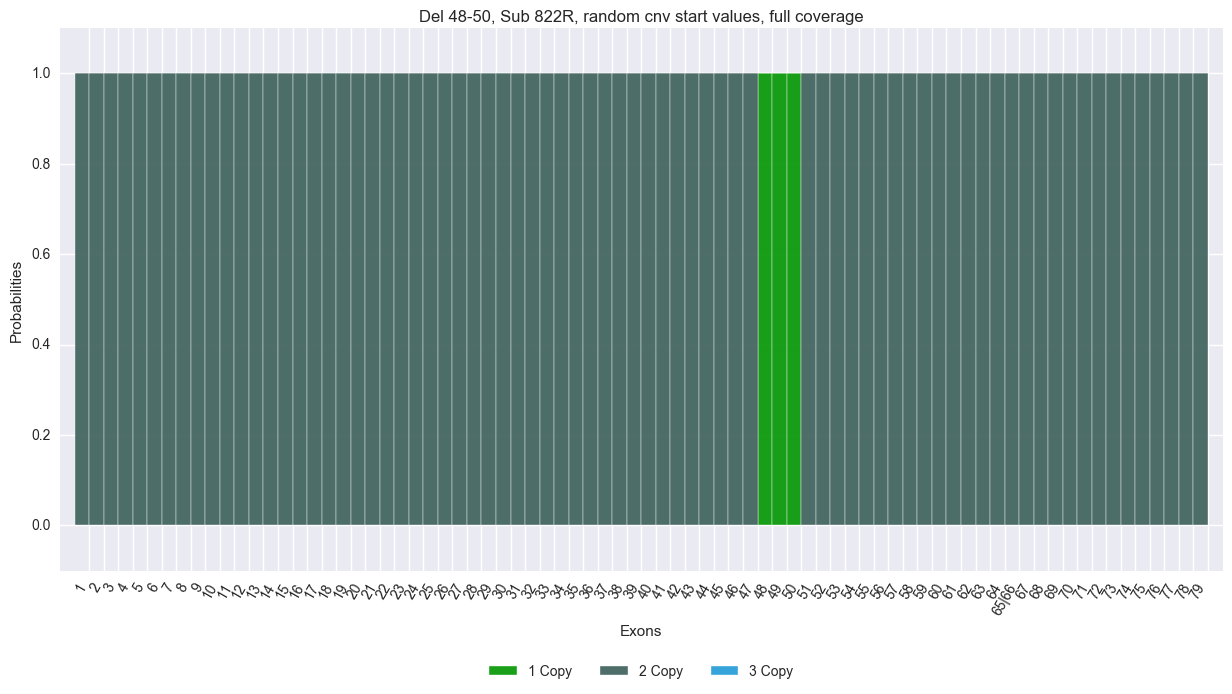

In [779]:
create_stacked_bars(gibbs_df_822R, 'Del 48-50, Sub 822R, random cnv start values, full coverage')

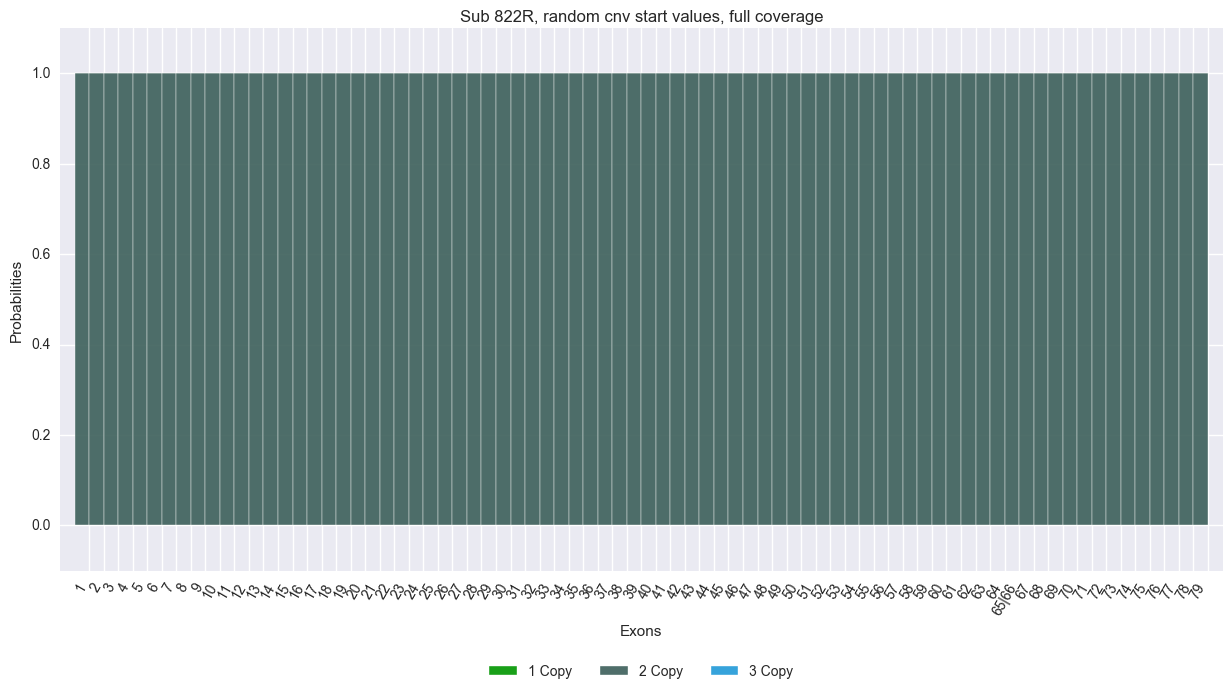

In [781]:
create_stacked_bars(gibbs_df_822Rc, 'Sub 822R, random cnv start values, full coverage')

(<matplotlib.text.Text at 0x116a6af10>, <matplotlib.text.Text at 0x11100c910>)

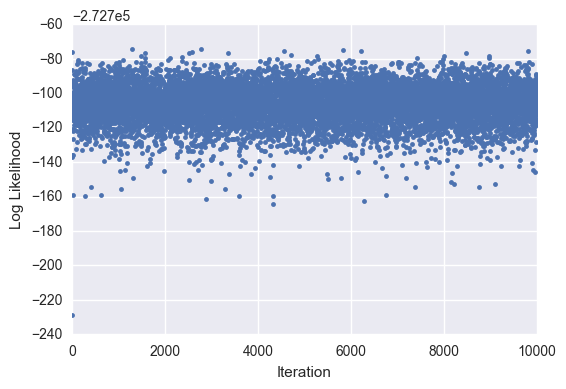

In [651]:
plt.figure()
plt.plot(range(len(logliks_822R2)), logliks_822R2, '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')

In [667]:
# this subject's mutation was simulated with a 0.65 mult factor (instead of 0.5) so I'm correcting for it here
data_dict['J0F1_del'][15:19] = (data_dict['J0F1_del'][15:19]) * (0.5 / 0.65)

In [782]:
%%time
cnv_support = [1,2,3]
gibbs_data_J0F1, gibbsX_J0F1, gibbs_data_results_J0F1, logliks_J0F1, gibbs_df_J0F1 = generate_gibbs_df(cnv_support, 
                                                                        X_probs43, data=data_dict['J0F1_del'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 2 2 1 3 3 3 3 2 2 1 3 3 3 1 1 3 3 1 3 1 3 2 1 3 2 1 2 1 1 1 1 3 3 3 1 3
 3 1 3 2 1 2 2 3 1 3 1 2 1 1 1 2 3 1 3 2 3 2 3 1 1 3 1 3 3 2 2 3 1 1 2 2 3
 2 2 3 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True
CPU times: user 1min 13s, sys: 343 ms, total: 1min 14s
Wall time: 1min 14s


In [783]:
cnv_support = [1,2,3]
gibbs_data_J0F1c, gibbsX_J0F1c, gibbs_data_results_J0F1c, logliks_J0F1c, gibbs_df_J0F1c = generate_gibbs_df(cnv_support, 
                                                                        X_probs43, data=data_dict['J0F1'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[2 3 3 3 3 3 1 1 3 3 1 3 1 1 2 3 3 3 2 1 3 2 2 3 1 3 3 1 3 3 2 2 2 2 3 1 3
 3 1 2 3 2 1 1 3 1 2 2 3 1 3 1 3 1 1 3 3 1 1 3 3 1 1 2 2 2 2 3 1 3 3 2 3 3
 3 3 2 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


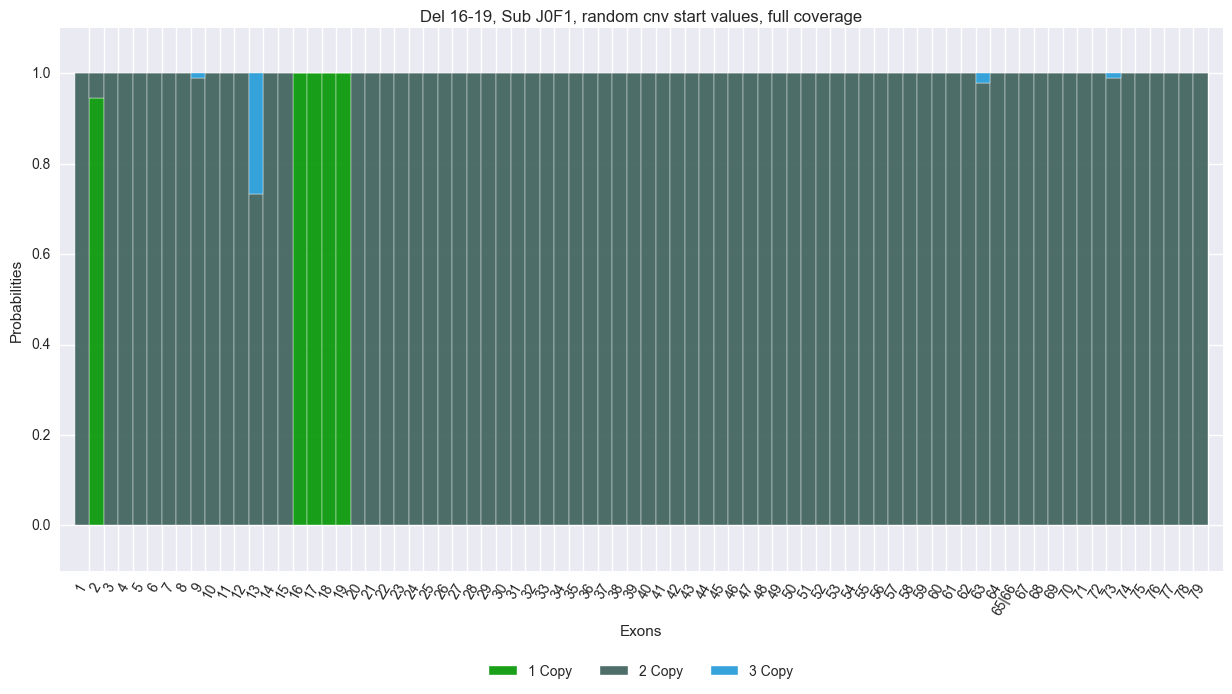

In [784]:
create_stacked_bars(gibbs_df_J0F1, 'Del 16-19, Sub J0F1, random cnv start values, full coverage')

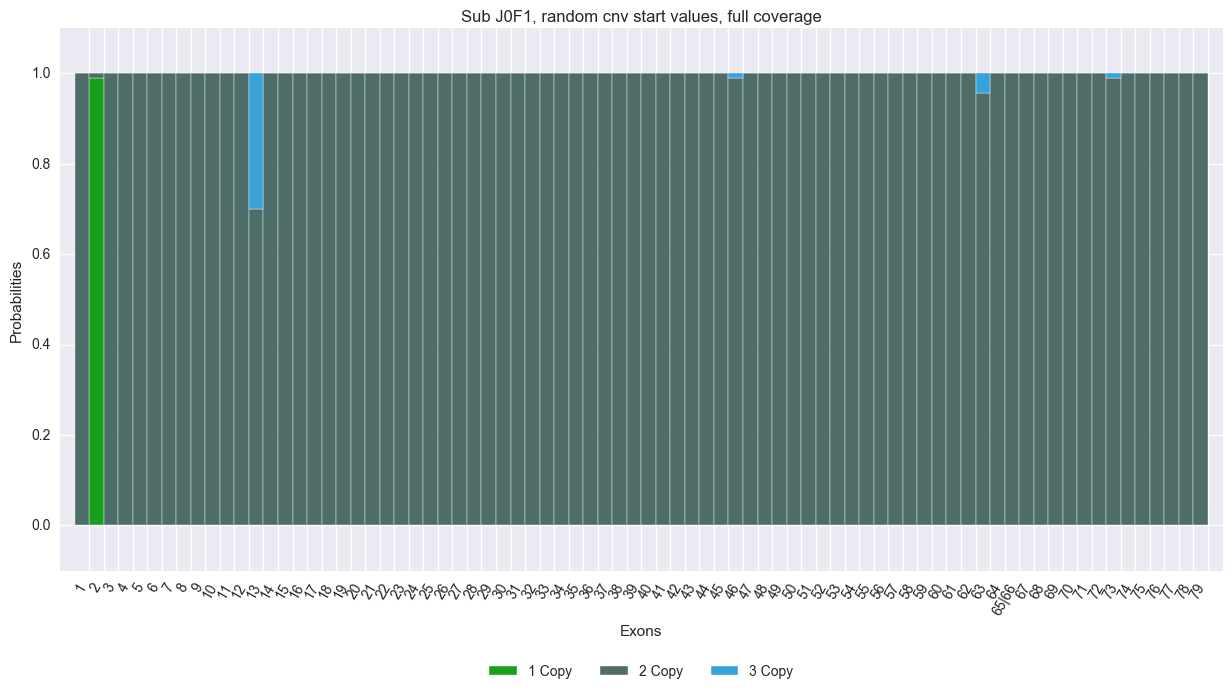

In [785]:
create_stacked_bars(gibbs_df_J0F1c, 'Sub J0F1, random cnv start values, full coverage')

In [786]:
cnv_support = [1,2,3]
gibbs_data_444F, gibbsX_444F, gibbs_data_results_444F, logliks_444F, gibbs_df_444F = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['444F_dup'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[1 1 1 1 3 3 3 3 3 3 1 2 2 2 1 3 2 2 2 2 2 1 3 3 3 2 1 3 3 1 3 2 2 1 1 1 1
 3 2 3 3 3 1 3 3 3 2 1 3 1 1 3 1 2 1 1 2 1 1 3 1 3 3 3 2 2 3 3 1 2 2 2 2 1
 3 2 2 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


In [787]:
cnv_support = [1,2,3]
gibbs_data_444Fc, gibbsX_444Fc, gibbs_data_results_444Fc, logliks_444Fc, gibbs_df_444Fc = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['444F'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[2 3 3 3 3 2 1 3 2 1 1 3 2 2 1 2 3 3 3 3 3 1 1 1 3 1 2 1 2 3 3 3 2 1 1 2 2
 2 1 1 2 1 1 2 1 3 1 1 2 1 3 1 1 2 2 1 3 1 1 2 3 2 3 2 1 2 1 3 1 3 2 3 2 3
 1 1 1 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


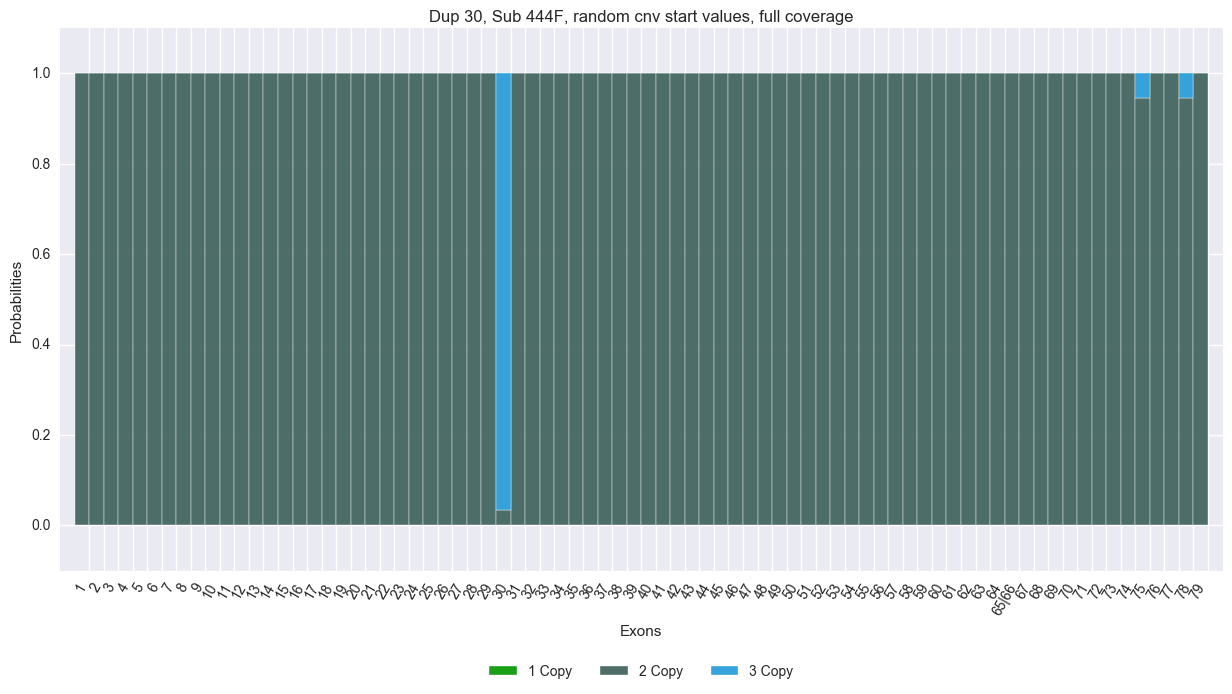

In [788]:
create_stacked_bars(gibbs_df_444F, 'Dup 30, Sub 444F, random cnv start values, full coverage')

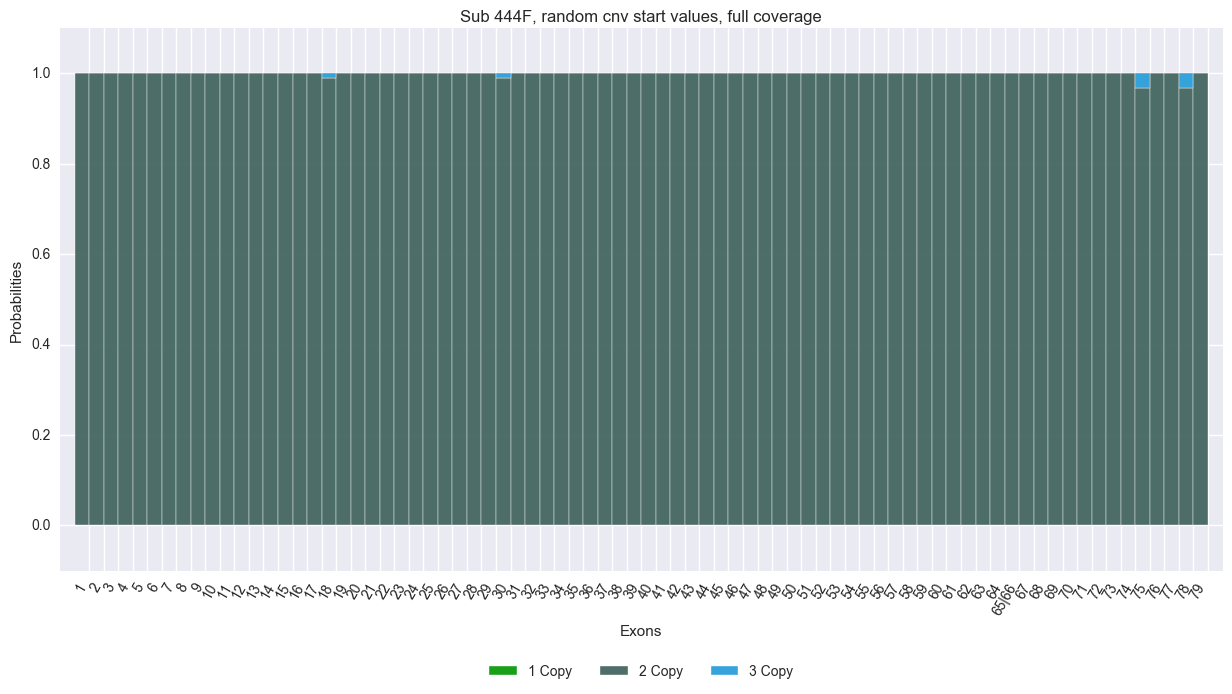

In [789]:
create_stacked_bars(gibbs_df_444Fc, 'Sub 444F, random cnv start values, full coverage')

This subject (and any simulated mutations based on her) will probably be excluded from future tests because her bams are actually merged files from the results of sequencing with at least two different mixin panels. This might explain the abnormal exon coverage ratios for at least some exons.

## Trying to predict underlying TSID ratio (based on single exon and full TSID_only ratios)

In [174]:
# getting coverage for Exon38 for these test subjects
exon38 = subject_norm.iloc[37]
print exon38[1:]

subject
FGPC-0000-444F        0.00627116
FGPC-0000-444F_dup    0.00625301
FGPC-4ZPF-J0F1        0.00560036
FGPC-4ZPF-J0F1_del    0.00568336
FPWB-0000-822R        0.00582354
FPWB-0000-822R_del    0.00595155
Name: 37, dtype: object


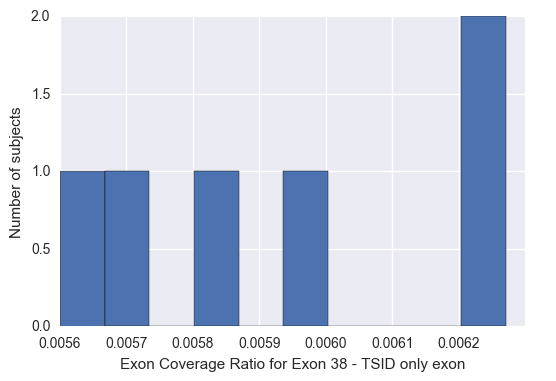

In [178]:
# seeing distribution of Exon38 coverage -- we expect three pairs since each simulated mut subject should have similar 
# coverage to its original subject
plt.figure()
plt.hist(exon38[1:])
plt.xlabel('Exon Coverage Ratio for Exon 38 - TSID only exon')
plt.ylabel('Number of subjects')

In [200]:
# get estimated TSID proportion for each subject based on regression coefficients from above -- all should be near 0.33
estimate_prop = (exon38[1:] - regression.params[0]) / regression.params[1]
print estimate_prop

subject
FGPC-0000-444F        0.339219
FGPC-0000-444F_dup    0.337637
FGPC-4ZPF-J0F1        0.280759
FGPC-4ZPF-J0F1_del    0.287993
FPWB-0000-822R        0.300209
FPWB-0000-822R_del    0.311365
Name: 37, dtype: object


In [269]:
test_grouped = test_subjects_rel.groupby('subject').sum()
test_norm_rel = test_grouped.div(test_grouped.sum(axis=1), axis=0)
test_norm_rel.head()

,TSID_only,TSO_only
subject,,
FGPC-0000-444F,0.379883,0.620117
FGPC-0000-444F_dup,0.379883,0.620117
FGPC-4ZPF-J0F1,0.430208,0.569792
FGPC-4ZPF-J0F1_del,0.430208,0.569792
FPWB-0000-822R,0.381978,0.618022


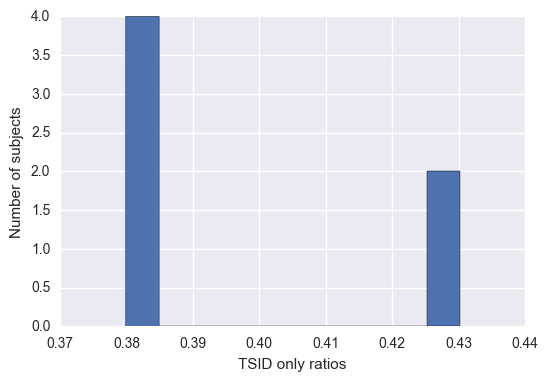

In [270]:
plt.figure()
plt.hist(test_norm_rel.TSID_only)
plt.xlabel('TSID only ratios')
plt.ylabel('Number of subjects')

In [273]:
estimate_prop_full = (test_norm_rel.TSID_only - regression_full.params[0]) / regression_full.params[1]
estimate_prop_full

subject
FGPC-0000-444F        0.349709
FGPC-0000-444F_dup    0.349709
FGPC-4ZPF-J0F1        0.404720
FGPC-4ZPF-J0F1_del    0.404720
FPWB-0000-822R        0.351999
FPWB-0000-822R_del    0.351999
Name: TSID_only, dtype: float64